In [61]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import time

# create lstm models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# hyperparameter tuning
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, Callback

# 1-Load Data

In [149]:
# load interim data set
data_set = pd.read_csv('../data/interim/international-airline-passengers.csv')
univariate_data_set = data_set["passenger_number"]
univariate_data_set

0      112.0
1      118.0
2      132.0
3      129.0
4      121.0
       ...  
139    606.0
140    508.0
141    461.0
142    390.0
143    432.0
Name: passenger_number, Length: 144, dtype: float64

In [16]:
univariate_array = univariate_data_set.values
univariate_array

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

# 2-Normalize Data

In [19]:
univariate_array_reshaped = univariate_array.reshape(-1, 1)
univariate_array_reshaped

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [30

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_univariate_array = scaler.fit_transform(univariate_array_reshaped)

# 3-Perform Train, Validation (2 years), Test Split (2 years)

In [213]:
train_size = len(normalized_univariate_array) - 48
validation_size = 24
test_size = 24
train_set, validation_set, test_set = normalized_univariate_array[0:train_size,:], normalized_univariate_array[train_size:train_size+validation_size,:], normalized_univariate_array[train_size+validation_size:len(normalized_univariate_array),:]
print(f"Training set: {len(train_set)}, validation set: {len(validation_set)}, test set: {len(test_set)}")

Training set: 96, validation set: 24, test set: 24


### I have allocated 24 months to both validation and test sets since I wanted to validate / evaluate on an entire year and as the maximal input window width is equal to 12, we need twice as much months in both sets.

# 4-Create samples using Moving Window Technique

In [214]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix][0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [215]:
def create_samples(train_set, validation_set, test_set, input_window_size, output_window_size):
    train_samples = split_sequence(train_set, input_window_size, output_window_size)
    val_samples = split_sequence(validation_set, input_window_size, output_window_size)
    test_samples = split_sequence(test_set, input_window_size, output_window_size)

    print(f"Number of training samples: {len(train_samples[0])}, validation samples: {len(val_samples[0])}, test samples: {len(test_samples[0])}")
    return train_samples, val_samples, test_samples

## Let's set size of the input window width to 12, becuase of the strong yearly seasonality

In [216]:
input_window_size = 12
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 84, validation samples: 12, test samples: 12


In [217]:
train_samples

(array([[[0.01544402],
         [0.02702703],
         [0.05405405],
         ...,
         [0.02895753],
         [0.        ],
         [0.02702703]],
 
        [[0.02702703],
         [0.05405405],
         [0.04826255],
         ...,
         [0.        ],
         [0.02702703],
         [0.02123552]],
 
        [[0.05405405],
         [0.04826255],
         [0.03281853],
         ...,
         [0.02702703],
         [0.02123552],
         [0.04247104]],
 
        ...,
 
        [[0.32818533],
         [0.25675676],
         [0.33590734],
         ...,
         [0.5965251 ],
         [0.58108108],
         [0.48455598]],
 
        [[0.25675676],
         [0.33590734],
         [0.34749035],
         ...,
         [0.58108108],
         [0.48455598],
         [0.38996139]],
 
        [[0.33590734],
         [0.34749035],
         [0.33397683],
         ...,
         [0.48455598],
         [0.38996139],
         [0.32239382]]]),
 array([[0.02123552],
        [0.04247104],
        [0.

# 5-Network Architecture

In [218]:
def build_model(hp):
    model = Sequential()
    # input LSTM layer
    model.add(LSTM(hp.Int("input_units", min_value=5, max_value=50, step=3),
                   activation='relu', input_shape=(input_window_size, 1), name="lstm"))
    
    # dense hidden layers with dropouts
    for i in range(hp.Int("n_layers", 0,2)):
        model.add(Dense(hp.Int(f"dense_{i}_units", min_value=5, max_value=50, step=3),
                        activation='relu', name=f"hidden_{i}"))
        for j in range(hp.Int("dropout_layers", 0, 1)):
            model.add(Dropout(hp.Choice(f"drop_rate_{j}", values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), name=f"dropout_{i}{j}"))
    
    # dense output layer
    model.add(Dense(1, name="output"))
    model.compile(loss='mean_squared_error' , optimizer=Adam(learning_rate=
            hp.Choice("learning_rate",values=[1e-2, 1e-3, 1e-4])), metrics=[metrics.mae])
    return model

In [219]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/{approach}_{input_window_size}")

Train on 84 samples, validate on 12 samples
Epoch 1/100
84/84 [==============================] - ETA: 1s - loss: 0.0872 - mean_absolute_error: 0.249 - 1s 13ms/sample - loss: 0.0858 - mean_absolute_error: 0.2569 - val_loss: 0.3523 - val_mean_absolute_error: 0.5815
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 0.0880 - mean_absolute_error: 0.244 - 0s 407us/sample - loss: 0.0841 - mean_absolute_error: 0.2538 - val_loss: 0.3464 - val_mean_absolute_error: 0.5764
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 0.0862 - mean_absolute_error: 0.263 - 0s 421us/sample - loss: 0.0824 - mean_absolute_error: 0.2507 - val_loss: 0.3406 - val_mean_absolute_error: 0.5713
Epoch 4/100
84/84 [==============================] - ETA: 0s - loss: 0.0701 - mean_absolute_error: 0.227 - 0s 375us/sample - loss: 0.0806 - mean_absolute_error: 0.2476 - val_loss: 0.3349 - val_mean_absolute_error: 0.5663
Epoch 5/100
84/84 [==============================] - ETA: 0s - loss: 0.09

Epoch 34/100
84/84 [==============================] - ETA: 0s - loss: 0.0357 - mean_absolute_error: 0.154 - 0s 390us/sample - loss: 0.0377 - mean_absolute_error: 0.1564 - val_loss: 0.1834 - val_mean_absolute_error: 0.4109
Epoch 35/100
84/84 [==============================] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.139 - 0s 424us/sample - loss: 0.0366 - mean_absolute_error: 0.1534 - val_loss: 0.1789 - val_mean_absolute_error: 0.4053
Epoch 36/100
84/84 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.140 - 0s 357us/sample - loss: 0.0353 - mean_absolute_error: 0.1502 - val_loss: 0.1743 - val_mean_absolute_error: 0.3997
Epoch 37/100
84/84 [==============================] - ETA: 0s - loss: 0.0337 - mean_absolute_error: 0.149 - 0s 360us/sample - loss: 0.0343 - mean_absolute_error: 0.1472 - val_loss: 0.1697 - val_mean_absolute_error: 0.3939
Epoch 38/100
84/84 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.142 - 0s 3

Epoch 71/100
84/84 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.063 - 0s 368us/sample - loss: 0.0079 - mean_absolute_error: 0.0693 - val_loss: 0.0389 - val_mean_absolute_error: 0.1566
Epoch 72/100
84/84 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.062 - 0s 327us/sample - loss: 0.0077 - mean_absolute_error: 0.0688 - val_loss: 0.0372 - val_mean_absolute_error: 0.1513
Epoch 73/100
84/84 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.071 - 0s 341us/sample - loss: 0.0076 - mean_absolute_error: 0.0682 - val_loss: 0.0357 - val_mean_absolute_error: 0.1465
Epoch 74/100
84/84 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.055 - 0s 336us/sample - loss: 0.0074 - mean_absolute_error: 0.0679 - val_loss: 0.0343 - val_mean_absolute_error: 0.1419
Epoch 75/100
84/84 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.062 - 0s 4

Epoch 8/100
84/84 [==============================] - ETA: 0s - loss: 0.0642 - mean_absolute_error: 0.219 - 0s 287us/sample - loss: 0.0662 - mean_absolute_error: 0.2226 - val_loss: 0.2763 - val_mean_absolute_error: 0.5114
Epoch 9/100
84/84 [==============================] - ETA: 0s - loss: 0.0641 - mean_absolute_error: 0.216 - 0s 289us/sample - loss: 0.0651 - mean_absolute_error: 0.2205 - val_loss: 0.2728 - val_mean_absolute_error: 0.5080
Epoch 10/100
84/84 [==============================] - ETA: 0s - loss: 0.0657 - mean_absolute_error: 0.217 - 0s 293us/sample - loss: 0.0641 - mean_absolute_error: 0.2184 - val_loss: 0.2693 - val_mean_absolute_error: 0.5045
Epoch 11/100
84/84 [==============================] - ETA: 0s - loss: 0.0697 - mean_absolute_error: 0.229 - 0s 271us/sample - loss: 0.0631 - mean_absolute_error: 0.2163 - val_loss: 0.2658 - val_mean_absolute_error: 0.5010
Epoch 12/100
84/84 [==============================] - ETA: 0s - loss: 0.0555 - mean_absolute_error: 0.197 - 0s 289

Epoch 45/100
84/84 [==============================] - ETA: 0s - loss: 0.0261 - mean_absolute_error: 0.120 - 0s 270us/sample - loss: 0.0283 - mean_absolute_error: 0.1321 - val_loss: 0.1396 - val_mean_absolute_error: 0.3525
Epoch 46/100
84/84 [==============================] - ETA: 0s - loss: 0.0206 - mean_absolute_error: 0.112 - 0s 295us/sample - loss: 0.0273 - mean_absolute_error: 0.1292 - val_loss: 0.1358 - val_mean_absolute_error: 0.3470
Epoch 47/100
84/84 [==============================] - ETA: 0s - loss: 0.0341 - mean_absolute_error: 0.153 - 0s 286us/sample - loss: 0.0264 - mean_absolute_error: 0.1264 - val_loss: 0.1319 - val_mean_absolute_error: 0.3413
Epoch 48/100
84/84 [==============================] - ETA: 0s - loss: 0.0302 - mean_absolute_error: 0.124 - 0s 260us/sample - loss: 0.0254 - mean_absolute_error: 0.1235 - val_loss: 0.1280 - val_mean_absolute_error: 0.3356
Epoch 49/100
84/84 [==============================] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.106 - 0s 2

Epoch 82/100
84/84 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.053 - 0s 342us/sample - loss: 0.0064 - mean_absolute_error: 0.0621 - val_loss: 0.0252 - val_mean_absolute_error: 0.1123
Epoch 83/100
84/84 [==============================] - ETA: 0s - loss: 0.0084 - mean_absolute_error: 0.066 - 0s 321us/sample - loss: 0.0063 - mean_absolute_error: 0.0616 - val_loss: 0.0244 - val_mean_absolute_error: 0.1097
Epoch 84/100
84/84 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.056 - 0s 271us/sample - loss: 0.0061 - mean_absolute_error: 0.0610 - val_loss: 0.0237 - val_mean_absolute_error: 0.1077
Epoch 85/100
84/84 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.063 - 0s 290us/sample - loss: 0.0060 - mean_absolute_error: 0.0605 - val_loss: 0.0231 - val_mean_absolute_error: 0.1062
Epoch 86/100
84/84 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.061 - 0s 2

Epoch 19/100
84/84 [==============================] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.166 - 0s 370us/sample - loss: 0.0473 - mean_absolute_error: 0.1832 - val_loss: 0.2070 - val_mean_absolute_error: 0.4390
Epoch 20/100
84/84 [==============================] - ETA: 0s - loss: 0.0386 - mean_absolute_error: 0.170 - 0s 271us/sample - loss: 0.0463 - mean_absolute_error: 0.1810 - val_loss: 0.2038 - val_mean_absolute_error: 0.4353
Epoch 21/100
84/84 [==============================] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.163 - 0s 262us/sample - loss: 0.0453 - mean_absolute_error: 0.1786 - val_loss: 0.2005 - val_mean_absolute_error: 0.4315
Epoch 22/100
84/84 [==============================] - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.178 - 0s 272us/sample - loss: 0.0444 - mean_absolute_error: 0.1762 - val_loss: 0.1971 - val_mean_absolute_error: 0.4276
Epoch 23/100
84/84 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.147 - 0s 2

Epoch 56/100
84/84 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.086 - 0s 291us/sample - loss: 0.0136 - mean_absolute_error: 0.0851 - val_loss: 0.0804 - val_mean_absolute_error: 0.2565
Epoch 57/100
84/84 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.079 - 0s 289us/sample - loss: 0.0130 - mean_absolute_error: 0.0831 - val_loss: 0.0768 - val_mean_absolute_error: 0.2496
Epoch 58/100
84/84 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.074 - 0s 264us/sample - loss: 0.0124 - mean_absolute_error: 0.0816 - val_loss: 0.0734 - val_mean_absolute_error: 0.2425
Epoch 59/100
84/84 [==============================] - ETA: 0s - loss: 0.0094 - mean_absolute_error: 0.072 - 0s 262us/sample - loss: 0.0118 - mean_absolute_error: 0.0800 - val_loss: 0.0700 - val_mean_absolute_error: 0.2355
Epoch 60/100
84/84 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.046 - 0s 2

Epoch 93/100
84/84 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.055 - 0s 343us/sample - loss: 0.0053 - mean_absolute_error: 0.0558 - val_loss: 0.0225 - val_mean_absolute_error: 0.1052
Epoch 94/100
84/84 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.054 - 0s 286us/sample - loss: 0.0053 - mean_absolute_error: 0.0554 - val_loss: 0.0221 - val_mean_absolute_error: 0.1040
Epoch 95/100
84/84 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.041 - 0s 289us/sample - loss: 0.0052 - mean_absolute_error: 0.0549 - val_loss: 0.0216 - val_mean_absolute_error: 0.1027
Epoch 96/100
84/84 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.042 - 0s 254us/sample - loss: 0.0051 - mean_absolute_error: 0.0547 - val_loss: 0.0211 - val_mean_absolute_error: 0.1012
Epoch 97/100
84/84 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.050 - 0s 2

Train on 84 samples, validate on 12 samples
Epoch 1/100
84/84 [==============================] - ETA: 1s - loss: 0.0985 - mean_absolute_error: 0.269 - 1s 11ms/sample - loss: 0.0907 - mean_absolute_error: 0.2634 - val_loss: 0.3578 - val_mean_absolute_error: 0.5859
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 0.0928 - mean_absolute_error: 0.261 - 0s 358us/sample - loss: 0.0807 - mean_absolute_error: 0.2456 - val_loss: 0.3290 - val_mean_absolute_error: 0.5608
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 0.0781 - mean_absolute_error: 0.240 - 0s 398us/sample - loss: 0.0716 - mean_absolute_error: 0.2291 - val_loss: 0.3006 - val_mean_absolute_error: 0.5349
Epoch 4/100
84/84 [==============================] - ETA: 0s - loss: 0.0728 - mean_absolute_error: 0.233 - 0s 337us/sample - loss: 0.0639 - mean_absolute_error: 0.2152 - val_loss: 0.2736 - val_mean_absolute_error: 0.5090
Epoch 5/100
84/84 [==============================] - ETA: 0s - loss: 0.05

Epoch 11/100
84/84 [==============================] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.111 - 0s 278us/sample - loss: 0.0218 - mean_absolute_error: 0.1122 - val_loss: 0.1102 - val_mean_absolute_error: 0.3098
Epoch 12/100
84/84 [==============================] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.112 - 0s 236us/sample - loss: 0.0182 - mean_absolute_error: 0.1008 - val_loss: 0.0956 - val_mean_absolute_error: 0.2852
Epoch 13/100
84/84 [==============================] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.098 - 0s 251us/sample - loss: 0.0152 - mean_absolute_error: 0.0909 - val_loss: 0.0782 - val_mean_absolute_error: 0.2524
Epoch 14/100
84/84 [==============================] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.086 - 0s 254us/sample - loss: 0.0123 - mean_absolute_error: 0.0830 - val_loss: 0.0622 - val_mean_absolute_error: 0.2183
Epoch 15/100
84/84 [==============================] - ETA: 0s - loss: 0.0129 - mean_absolute_error: 0.089 - 0s 2

Epoch 18/100
84/84 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.053 - 0s 264us/sample - loss: 0.0067 - mean_absolute_error: 0.0626 - val_loss: 0.0335 - val_mean_absolute_error: 0.1406
Epoch 19/100
84/84 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.058 - 0s 271us/sample - loss: 0.0061 - mean_absolute_error: 0.0604 - val_loss: 0.0282 - val_mean_absolute_error: 0.1231
Epoch 20/100
84/84 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.057 - 0s 255us/sample - loss: 0.0056 - mean_absolute_error: 0.0579 - val_loss: 0.0237 - val_mean_absolute_error: 0.1089
Epoch 21/100
84/84 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.056 - 0s 250us/sample - loss: 0.0054 - mean_absolute_error: 0.0577 - val_loss: 0.0206 - val_mean_absolute_error: 0.1013
Epoch 22/100
84/84 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.067 - 0s 2

Train on 84 samples, validate on 12 samples
Epoch 1/100
84/84 [==============================] - ETA: 1s - loss: 0.0843 - mean_absolute_error: 0.258 - 1s 11ms/sample - loss: 0.0891 - mean_absolute_error: 0.2613 - val_loss: 0.3684 - val_mean_absolute_error: 0.5948
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 0.0680 - mean_absolute_error: 0.233 - 0s 348us/sample - loss: 0.0884 - mean_absolute_error: 0.2600 - val_loss: 0.3658 - val_mean_absolute_error: 0.5925
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 0.0933 - mean_absolute_error: 0.277 - 0s 351us/sample - loss: 0.0876 - mean_absolute_error: 0.2588 - val_loss: 0.3632 - val_mean_absolute_error: 0.5904
Epoch 4/100
84/84 [==============================] - ETA: 0s - loss: 0.1095 - mean_absolute_error: 0.284 - 0s 335us/sample - loss: 0.0863 - mean_absolute_error: 0.2562 - val_loss: 0.3607 - val_mean_absolute_error: 0.5883
Epoch 5/100
84/84 [==============================] - ETA: 0s - loss: 0.08

Epoch 38/100
84/84 [==============================] - ETA: 0s - loss: 0.0666 - mean_absolute_error: 0.214 - 0s 373us/sample - loss: 0.0565 - mean_absolute_error: 0.1994 - val_loss: 0.2645 - val_mean_absolute_error: 0.5000
Epoch 39/100
84/84 [==============================] - ETA: 0s - loss: 0.0675 - mean_absolute_error: 0.219 - 0s 334us/sample - loss: 0.0563 - mean_absolute_error: 0.1984 - val_loss: 0.2621 - val_mean_absolute_error: 0.4976
Epoch 40/100
84/84 [==============================] - ETA: 0s - loss: 0.0494 - mean_absolute_error: 0.181 - 0s 353us/sample - loss: 0.0544 - mean_absolute_error: 0.1950 - val_loss: 0.2597 - val_mean_absolute_error: 0.4952
Epoch 41/100
84/84 [==============================] - ETA: 0s - loss: 0.0549 - mean_absolute_error: 0.185 - 0s 352us/sample - loss: 0.0544 - mean_absolute_error: 0.1944 - val_loss: 0.2574 - val_mean_absolute_error: 0.4929
Epoch 42/100
84/84 [==============================] - ETA: 0s - loss: 0.0437 - mean_absolute_error: 0.176 - 0s 3

Epoch 75/100
84/84 [==============================] - ETA: 0s - loss: 0.0275 - mean_absolute_error: 0.122 - 0s 339us/sample - loss: 0.0306 - mean_absolute_error: 0.1356 - val_loss: 0.1719 - val_mean_absolute_error: 0.3968
Epoch 76/100
84/84 [==============================] - ETA: 0s - loss: 0.0401 - mean_absolute_error: 0.149 - 0s 323us/sample - loss: 0.0306 - mean_absolute_error: 0.1330 - val_loss: 0.1690 - val_mean_absolute_error: 0.3931
Epoch 77/100
84/84 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.145 - 0s 330us/sample - loss: 0.0297 - mean_absolute_error: 0.1324 - val_loss: 0.1660 - val_mean_absolute_error: 0.3893
Epoch 78/100
84/84 [==============================] - ETA: 0s - loss: 0.0433 - mean_absolute_error: 0.159 - 0s 328us/sample - loss: 0.0269 - mean_absolute_error: 0.1254 - val_loss: 0.1629 - val_mean_absolute_error: 0.3853
Epoch 79/100
84/84 [==============================] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.124 - 0s 3

Epoch 12/100
84/84 [==============================] - ETA: 0s - loss: 0.0729 - mean_absolute_error: 0.231 - 0s 267us/sample - loss: 0.0692 - mean_absolute_error: 0.2254 - val_loss: 0.2978 - val_mean_absolute_error: 0.5323
Epoch 13/100
84/84 [==============================] - ETA: 0s - loss: 0.0825 - mean_absolute_error: 0.237 - 0s 270us/sample - loss: 0.0677 - mean_absolute_error: 0.2229 - val_loss: 0.2938 - val_mean_absolute_error: 0.5285
Epoch 14/100
84/84 [==============================] - ETA: 0s - loss: 0.0829 - mean_absolute_error: 0.238 - 0s 281us/sample - loss: 0.0659 - mean_absolute_error: 0.2195 - val_loss: 0.2895 - val_mean_absolute_error: 0.5245
Epoch 15/100
84/84 [==============================] - ETA: 0s - loss: 0.0584 - mean_absolute_error: 0.204 - 0s 267us/sample - loss: 0.0650 - mean_absolute_error: 0.2174 - val_loss: 0.2853 - val_mean_absolute_error: 0.5204
Epoch 16/100
84/84 [==============================] - ETA: 0s - loss: 0.0741 - mean_absolute_error: 0.228 - 0s 2

Epoch 49/100
84/84 [==============================] - ETA: 0s - loss: 0.0264 - mean_absolute_error: 0.127 - 0s 289us/sample - loss: 0.0323 - mean_absolute_error: 0.1403 - val_loss: 0.1694 - val_mean_absolute_error: 0.3937
Epoch 50/100
84/84 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.131 - 0s 274us/sample - loss: 0.0319 - mean_absolute_error: 0.1394 - val_loss: 0.1665 - val_mean_absolute_error: 0.3901
Epoch 51/100
84/84 [==============================] - ETA: 0s - loss: 0.0339 - mean_absolute_error: 0.152 - 0s 279us/sample - loss: 0.0304 - mean_absolute_error: 0.1358 - val_loss: 0.1637 - val_mean_absolute_error: 0.3864
Epoch 52/100
84/84 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.135 - 0s 265us/sample - loss: 0.0297 - mean_absolute_error: 0.1348 - val_loss: 0.1608 - val_mean_absolute_error: 0.3826
Epoch 53/100
84/84 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.135 - 0s 2

Epoch 86/100
84/84 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.077 - 0s 337us/sample - loss: 0.0112 - mean_absolute_error: 0.0782 - val_loss: 0.0620 - val_mean_absolute_error: 0.2188
Epoch 87/100
84/84 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.065 - 0s 335us/sample - loss: 0.0109 - mean_absolute_error: 0.0778 - val_loss: 0.0601 - val_mean_absolute_error: 0.2144
Epoch 88/100
84/84 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.073 - 0s 379us/sample - loss: 0.0096 - mean_absolute_error: 0.0767 - val_loss: 0.0582 - val_mean_absolute_error: 0.2100
Epoch 89/100
84/84 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.086 - 0s 335us/sample - loss: 0.0106 - mean_absolute_error: 0.0801 - val_loss: 0.0565 - val_mean_absolute_error: 0.2060
Epoch 90/100
84/84 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.069 - 0s 3

Epoch 23/100
84/84 [==============================] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.141 - 0s 273us/sample - loss: 0.0339 - mean_absolute_error: 0.1476 - val_loss: 0.1539 - val_mean_absolute_error: 0.3737
Epoch 24/100
84/84 [==============================] - ETA: 0s - loss: 0.0287 - mean_absolute_error: 0.138 - 0s 257us/sample - loss: 0.0307 - mean_absolute_error: 0.1411 - val_loss: 0.1503 - val_mean_absolute_error: 0.3686
Epoch 25/100
84/84 [==============================] - ETA: 0s - loss: 0.0362 - mean_absolute_error: 0.156 - 0s 247us/sample - loss: 0.0314 - mean_absolute_error: 0.1407 - val_loss: 0.1461 - val_mean_absolute_error: 0.3629
Epoch 26/100
84/84 [==============================] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.100 - 0s 252us/sample - loss: 0.0285 - mean_absolute_error: 0.1355 - val_loss: 0.1417 - val_mean_absolute_error: 0.3566
Epoch 27/100
84/84 [==============================] - ETA: 0s - loss: 0.0268 - mean_absolute_error: 0.130 - 0s 2

Epoch 60/100
84/84 [==============================] - ETA: 0s - loss: 0.0127 - mean_absolute_error: 0.080 - 0s 340us/sample - loss: 0.0092 - mean_absolute_error: 0.0706 - val_loss: 0.0407 - val_mean_absolute_error: 0.1611
Epoch 61/100
84/84 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.067 - 0s 358us/sample - loss: 0.0079 - mean_absolute_error: 0.0687 - val_loss: 0.0395 - val_mean_absolute_error: 0.1575
Epoch 62/100
84/84 [==============================] - ETA: 0s - loss: 0.0101 - mean_absolute_error: 0.067 - 0s 399us/sample - loss: 0.0081 - mean_absolute_error: 0.0659 - val_loss: 0.0384 - val_mean_absolute_error: 0.1547
Epoch 63/100
84/84 [==============================] - ETA: 0s - loss: 0.0093 - mean_absolute_error: 0.075 - 0s 315us/sample - loss: 0.0068 - mean_absolute_error: 0.0638 - val_loss: 0.0373 - val_mean_absolute_error: 0.1517
Epoch 64/100
84/84 [==============================] - ETA: 0s - loss: 0.0116 - mean_absolute_error: 0.081 - 0s 3

Epoch 97/100
84/84 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.063 - 0s 332us/sample - loss: 0.0067 - mean_absolute_error: 0.0650 - val_loss: 0.0201 - val_mean_absolute_error: 0.0985
Epoch 98/100
84/84 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.066 - 0s 335us/sample - loss: 0.0055 - mean_absolute_error: 0.0573 - val_loss: 0.0198 - val_mean_absolute_error: 0.0979
Epoch 99/100
84/84 [==============================] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.056 - 0s 353us/sample - loss: 0.0067 - mean_absolute_error: 0.0627 - val_loss: 0.0197 - val_mean_absolute_error: 0.0975
Epoch 100/100
84/84 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.060 - 0s 354us/sample - loss: 0.0049 - mean_absolute_error: 0.0529 - val_loss: 0.0195 - val_mean_absolute_error: 0.0973


Train on 84 samples, validate on 12 samples
Epoch 1/100
84/84 [==============================] - ETA: 1s - loss: 0.0604 - mean_absolute_error: 0.209 - 1s 13ms/sample - loss: 0.0673 - mean_absolute_error: 0.2260 - val_loss: 0.2620 - val_mean_absolute_error: 0.4980
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.229 - 0s 329us/sample - loss: 0.0593 - mean_absolute_error: 0.2090 - val_loss: 0.2367 - val_mean_absolute_error: 0.4719
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 0.0487 - mean_absolute_error: 0.184 - 0s 375us/sample - loss: 0.0514 - mean_absolute_error: 0.1918 - val_loss: 0.2127 - val_mean_absolute_error: 0.4457
Epoch 4/100
84/84 [==============================] - ETA: 0s - loss: 0.0450 - mean_absolute_error: 0.174 - 0s 359us/sample - loss: 0.0444 - mean_absolute_error: 0.1744 - val_loss: 0.1891 - val_mean_absolute_error: 0.4181
Epoch 5/100
84/84 [==============================] - ETA: 0s - loss: 0.03

84/84 [==============================] - ETA: 1s - loss: 0.0566 - mean_absolute_error: 0.205 - 1s 10ms/sample - loss: 0.0591 - mean_absolute_error: 0.2109 - val_loss: 0.2162 - val_mean_absolute_error: 0.4494
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 0.0470 - mean_absolute_error: 0.195 - 0s 277us/sample - loss: 0.0484 - mean_absolute_error: 0.1867 - val_loss: 0.1825 - val_mean_absolute_error: 0.4103
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 0.0450 - mean_absolute_error: 0.177 - 0s 290us/sample - loss: 0.0391 - mean_absolute_error: 0.1637 - val_loss: 0.1530 - val_mean_absolute_error: 0.3725
Epoch 4/100
84/84 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.169 - 0s 300us/sample - loss: 0.0310 - mean_absolute_error: 0.1418 - val_loss: 0.1249 - val_mean_absolute_error: 0.3325
Epoch 5/100
84/84 [==============================] - ETA: 0s - loss: 0.0278 - mean_absolute_error: 0.129 - 0s 315us/sample - loss

Train on 84 samples, validate on 12 samples
Epoch 1/100
84/84 [==============================] - ETA: 1s - loss: 0.0570 - mean_absolute_error: 0.209 - 1s 11ms/sample - loss: 0.0484 - mean_absolute_error: 0.1813 - val_loss: 0.0412 - val_mean_absolute_error: 0.1650
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 0.0168 - mean_absolute_error: 0.104 - 0s 353us/sample - loss: 0.0172 - mean_absolute_error: 0.1096 - val_loss: 0.0185 - val_mean_absolute_error: 0.0960
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.107 - 0s 291us/sample - loss: 0.0135 - mean_absolute_error: 0.0978 - val_loss: 0.0578 - val_mean_absolute_error: 0.2095
Epoch 4/100
84/84 [==============================] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.107 - 0s 249us/sample - loss: 0.0144 - mean_absolute_error: 0.0888 - val_loss: 0.0755 - val_mean_absolute_error: 0.2486
Epoch 5/100
84/84 [==============================] - ETA: 0s - loss: 0.01

Epoch 5/100
84/84 [==============================] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.096 - 0s 238us/sample - loss: 0.0128 - mean_absolute_error: 0.0854 - val_loss: 0.0622 - val_mean_absolute_error: 0.2200
Epoch 6/100
84/84 [==============================] - ETA: 0s - loss: 0.0162 - mean_absolute_error: 0.099 - 0s 257us/sample - loss: 0.0138 - mean_absolute_error: 0.0910 - val_loss: 0.0471 - val_mean_absolute_error: 0.1821
Epoch 7/100
84/84 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.078 - 0s 249us/sample - loss: 0.0122 - mean_absolute_error: 0.0904 - val_loss: 0.0321 - val_mean_absolute_error: 0.1394
Train on 84 samples, validate on 12 samples
Epoch 1/100
84/84 [==============================] - ETA: 1s - loss: 0.0925 - mean_absolute_error: 0.273 - 1s 10ms/sample - loss: 0.0569 - mean_absolute_error: 0.1970 - val_loss: 0.1169 - val_mean_absolute_error: 0.3204
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 0.03

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/univariate_12/assets


# 6-Make &Denormalize Predictions

In [220]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

array([[0.57772064],
       [0.58701605],
       [0.5929419 ],
       [0.5939109 ],
       [0.60315114],
       [0.6104844 ],
       [0.61603653],
       [0.61897254],
       [0.6253072 ],
       [0.6380477 ],
       [0.6528957 ],
       [0.66027725]], dtype=float32)

In [221]:
# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# 7-Evaluation

In [222]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 36.68 RMSE
Validation Score: 67.99 RMSE
Test Score: 92.07 RMSE


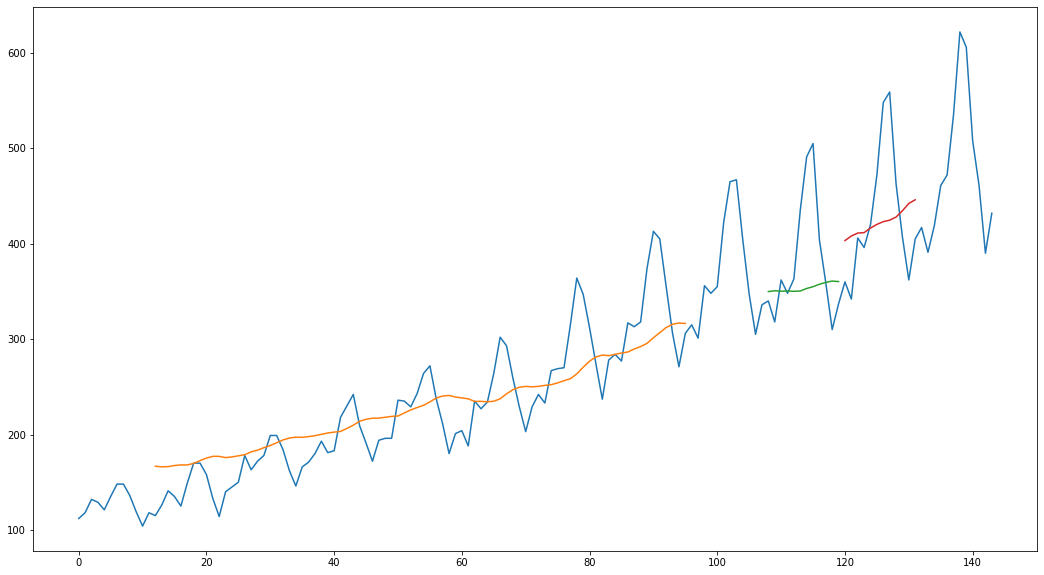

In [223]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

# 8-Conclusion

### This combination of architecture and input window size performed quite poorly. Let's try different input window width and then adjust the network architecture.

# 9-Further experiments

### Let's decrease the input window size to 6 months

In [224]:
input_window_size = 6
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 90, validation samples: 18, test samples: 18


In [225]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/{approach}_{input_window_size}")

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0721 - mean_absolute_error: 0.240 - 1s 11ms/sample - loss: 0.0759 - mean_absolute_error: 0.2361 - val_loss: 0.3396 - val_mean_absolute_error: 0.5701
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.216 - 0s 337us/sample - loss: 0.0747 - mean_absolute_error: 0.2337 - val_loss: 0.3354 - val_mean_absolute_error: 0.5664
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0943 - mean_absolute_error: 0.264 - 0s 345us/sample - loss: 0.0735 - mean_absolute_error: 0.2314 - val_loss: 0.3312 - val_mean_absolute_error: 0.5627
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0922 - mean_absolute_error: 0.267 - 0s 379us/sample - loss: 0.0723 - mean_absolute_error: 0.2291 - val_loss: 0.3272 - val_mean_absolute_error: 0.5590
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.08

Epoch 34/100
90/90 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.160 - 0s 319us/sample - loss: 0.0433 - mean_absolute_error: 0.1672 - val_loss: 0.2241 - val_mean_absolute_error: 0.4568
Epoch 35/100
90/90 [==============================] - ETA: 0s - loss: 0.0509 - mean_absolute_error: 0.180 - 0s 326us/sample - loss: 0.0425 - mean_absolute_error: 0.1652 - val_loss: 0.2209 - val_mean_absolute_error: 0.4532
Epoch 36/100
90/90 [==============================] - ETA: 0s - loss: 0.0466 - mean_absolute_error: 0.177 - 0s 305us/sample - loss: 0.0417 - mean_absolute_error: 0.1632 - val_loss: 0.2176 - val_mean_absolute_error: 0.4496
Epoch 37/100
90/90 [==============================] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.167 - 0s 310us/sample - loss: 0.0408 - mean_absolute_error: 0.1612 - val_loss: 0.2144 - val_mean_absolute_error: 0.4460
Epoch 38/100
90/90 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.151 - 0s 2

Epoch 71/100
90/90 [==============================] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.105 - 0s 279us/sample - loss: 0.0183 - mean_absolute_error: 0.0999 - val_loss: 0.1176 - val_mean_absolute_error: 0.3177
Epoch 72/100
90/90 [==============================] - ETA: 0s - loss: 0.0225 - mean_absolute_error: 0.114 - 0s 280us/sample - loss: 0.0178 - mean_absolute_error: 0.0984 - val_loss: 0.1150 - val_mean_absolute_error: 0.3136
Epoch 73/100
90/90 [==============================] - ETA: 0s - loss: 0.0207 - mean_absolute_error: 0.103 - 0s 264us/sample - loss: 0.0173 - mean_absolute_error: 0.0970 - val_loss: 0.1126 - val_mean_absolute_error: 0.3096
Epoch 74/100
90/90 [==============================] - ETA: 0s - loss: 0.0158 - mean_absolute_error: 0.089 - 0s 251us/sample - loss: 0.0169 - mean_absolute_error: 0.0956 - val_loss: 0.1101 - val_mean_absolute_error: 0.3056
Epoch 75/100
90/90 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.087 - 0s 2

Epoch 8/100
90/90 [==============================] - ETA: 0s - loss: 0.0597 - mean_absolute_error: 0.210 - 0s 195us/sample - loss: 0.0687 - mean_absolute_error: 0.2224 - val_loss: 0.3125 - val_mean_absolute_error: 0.5458
Epoch 9/100
90/90 [==============================] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.208 - 0s 225us/sample - loss: 0.0678 - mean_absolute_error: 0.2206 - val_loss: 0.3095 - val_mean_absolute_error: 0.5430
Epoch 10/100
90/90 [==============================] - ETA: 0s - loss: 0.0664 - mean_absolute_error: 0.223 - 0s 203us/sample - loss: 0.0669 - mean_absolute_error: 0.2188 - val_loss: 0.3065 - val_mean_absolute_error: 0.5402
Epoch 11/100
90/90 [==============================] - ETA: 0s - loss: 0.0713 - mean_absolute_error: 0.229 - 0s 190us/sample - loss: 0.0661 - mean_absolute_error: 0.2171 - val_loss: 0.3036 - val_mean_absolute_error: 0.5375
Epoch 12/100
90/90 [==============================] - ETA: 0s - loss: 0.0798 - mean_absolute_error: 0.241 - 0s 201

Epoch 45/100
90/90 [==============================] - ETA: 0s - loss: 0.0320 - mean_absolute_error: 0.144 - 0s 223us/sample - loss: 0.0377 - mean_absolute_error: 0.1523 - val_loss: 0.2049 - val_mean_absolute_error: 0.4351
Epoch 46/100
90/90 [==============================] - ETA: 0s - loss: 0.0258 - mean_absolute_error: 0.127 - 0s 208us/sample - loss: 0.0368 - mean_absolute_error: 0.1503 - val_loss: 0.2019 - val_mean_absolute_error: 0.4316
Epoch 47/100
90/90 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.133 - 0s 205us/sample - loss: 0.0361 - mean_absolute_error: 0.1482 - val_loss: 0.1989 - val_mean_absolute_error: 0.4281
Epoch 48/100
90/90 [==============================] - ETA: 0s - loss: 0.0485 - mean_absolute_error: 0.172 - 0s 189us/sample - loss: 0.0353 - mean_absolute_error: 0.1464 - val_loss: 0.1958 - val_mean_absolute_error: 0.4244
Epoch 49/100
90/90 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.128 - 0s 2

Epoch 82/100
90/90 [==============================] - ETA: 0s - loss: 0.0131 - mean_absolute_error: 0.080 - 0s 199us/sample - loss: 0.0151 - mean_absolute_error: 0.0905 - val_loss: 0.1033 - val_mean_absolute_error: 0.2937
Epoch 83/100
90/90 [==============================] - ETA: 0s - loss: 0.0132 - mean_absolute_error: 0.083 - 0s 184us/sample - loss: 0.0148 - mean_absolute_error: 0.0895 - val_loss: 0.1011 - val_mean_absolute_error: 0.2898
Epoch 84/100
90/90 [==============================] - ETA: 0s - loss: 0.0150 - mean_absolute_error: 0.087 - 0s 193us/sample - loss: 0.0144 - mean_absolute_error: 0.0886 - val_loss: 0.0988 - val_mean_absolute_error: 0.2859
Epoch 85/100
90/90 [==============================] - ETA: 0s - loss: 0.0104 - mean_absolute_error: 0.075 - 0s 192us/sample - loss: 0.0140 - mean_absolute_error: 0.0877 - val_loss: 0.0967 - val_mean_absolute_error: 0.2821
Epoch 86/100
90/90 [==============================] - ETA: 0s - loss: 0.0138 - mean_absolute_error: 0.084 - 0s 1

Epoch 19/100
90/90 [==============================] - ETA: 0s - loss: 0.0279 - mean_absolute_error: 0.137 - 0s 190us/sample - loss: 0.0377 - mean_absolute_error: 0.1594 - val_loss: 0.1790 - val_mean_absolute_error: 0.4058
Epoch 20/100
90/90 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.139 - 0s 211us/sample - loss: 0.0370 - mean_absolute_error: 0.1574 - val_loss: 0.1766 - val_mean_absolute_error: 0.4028
Epoch 21/100
90/90 [==============================] - ETA: 0s - loss: 0.0382 - mean_absolute_error: 0.157 - 0s 217us/sample - loss: 0.0363 - mean_absolute_error: 0.1556 - val_loss: 0.1742 - val_mean_absolute_error: 0.3997
Epoch 22/100
90/90 [==============================] - ETA: 0s - loss: 0.0392 - mean_absolute_error: 0.161 - 0s 209us/sample - loss: 0.0356 - mean_absolute_error: 0.1537 - val_loss: 0.1717 - val_mean_absolute_error: 0.3967
Epoch 23/100
90/90 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.152 - 0s 2

Epoch 56/100
90/90 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.085 - 0s 235us/sample - loss: 0.0158 - mean_absolute_error: 0.0934 - val_loss: 0.0935 - val_mean_absolute_error: 0.2796
Epoch 57/100
90/90 [==============================] - ETA: 0s - loss: 0.0115 - mean_absolute_error: 0.077 - 0s 211us/sample - loss: 0.0154 - mean_absolute_error: 0.0919 - val_loss: 0.0915 - val_mean_absolute_error: 0.2760
Epoch 58/100
90/90 [==============================] - ETA: 0s - loss: 0.0133 - mean_absolute_error: 0.087 - 0s 212us/sample - loss: 0.0150 - mean_absolute_error: 0.0907 - val_loss: 0.0895 - val_mean_absolute_error: 0.2723
Epoch 59/100
90/90 [==============================] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.092 - 0s 199us/sample - loss: 0.0146 - mean_absolute_error: 0.0892 - val_loss: 0.0876 - val_mean_absolute_error: 0.2687
Epoch 60/100
90/90 [==============================] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.100 - 0s 2

Epoch 93/100
90/90 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.073 - 0s 259us/sample - loss: 0.0073 - mean_absolute_error: 0.0658 - val_loss: 0.0432 - val_mean_absolute_error: 0.1663
Epoch 94/100
90/90 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.064 - 0s 271us/sample - loss: 0.0072 - mean_absolute_error: 0.0655 - val_loss: 0.0425 - val_mean_absolute_error: 0.1646
Epoch 95/100
90/90 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.053 - 0s 285us/sample - loss: 0.0072 - mean_absolute_error: 0.0652 - val_loss: 0.0419 - val_mean_absolute_error: 0.1630
Epoch 96/100
90/90 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.062 - 0s 306us/sample - loss: 0.0071 - mean_absolute_error: 0.0649 - val_loss: 0.0412 - val_mean_absolute_error: 0.1613
Epoch 97/100
90/90 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.068 - 0s 2

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0815 - mean_absolute_error: 0.245 - 1s 10ms/sample - loss: 0.0483 - mean_absolute_error: 0.1744 - val_loss: 0.1005 - val_mean_absolute_error: 0.2921
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0112 - mean_absolute_error: 0.075 - 0s 300us/sample - loss: 0.0132 - mean_absolute_error: 0.0922 - val_loss: 0.0194 - val_mean_absolute_error: 0.1114
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0232 - mean_absolute_error: 0.138 - 0s 231us/sample - loss: 0.0182 - mean_absolute_error: 0.1179 - val_loss: 0.0473 - val_mean_absolute_error: 0.1780
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.087 - 0s 223us/sample - loss: 0.0124 - mean_absolute_error: 0.0885 - val_loss: 0.0862 - val_mean_absolute_error: 0.2670
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.01

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0908 - mean_absolute_error: 0.245 - 1s 9ms/sample - loss: 0.0790 - mean_absolute_error: 0.2401 - val_loss: 0.3381 - val_mean_absolute_error: 0.5687
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0702 - mean_absolute_error: 0.214 - 0s 263us/sample - loss: 0.0700 - mean_absolute_error: 0.2234 - val_loss: 0.3112 - val_mean_absolute_error: 0.5444
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0682 - mean_absolute_error: 0.228 - 0s 282us/sample - loss: 0.0630 - mean_absolute_error: 0.2096 - val_loss: 0.2871 - val_mean_absolute_error: 0.5219
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0592 - mean_absolute_error: 0.196 - 0s 246us/sample - loss: 0.0570 - mean_absolute_error: 0.1975 - val_loss: 0.2670 - val_mean_absolute_error: 0.5022
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.057

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0723 - mean_absolute_error: 0.233 - 1s 12ms/sample - loss: 0.0641 - mean_absolute_error: 0.2151 - val_loss: 0.2697 - val_mean_absolute_error: 0.5052
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0502 - mean_absolute_error: 0.193 - 0s 203us/sample - loss: 0.0554 - mean_absolute_error: 0.1972 - val_loss: 0.2434 - val_mean_absolute_error: 0.4783
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0495 - mean_absolute_error: 0.185 - 0s 220us/sample - loss: 0.0485 - mean_absolute_error: 0.1817 - val_loss: 0.2195 - val_mean_absolute_error: 0.4524
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.144 - 0s 206us/sample - loss: 0.0420 - mean_absolute_error: 0.1669 - val_loss: 0.1981 - val_mean_absolute_error: 0.4279
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.03

Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0593 - mean_absolute_error: 0.200 - 0s 198us/sample - loss: 0.0544 - mean_absolute_error: 0.1948 - val_loss: 0.2345 - val_mean_absolute_error: 0.4691
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0561 - mean_absolute_error: 0.188 - 0s 221us/sample - loss: 0.0461 - mean_absolute_error: 0.1759 - val_loss: 0.2068 - val_mean_absolute_error: 0.4385
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0272 - mean_absolute_error: 0.137 - 0s 215us/sample - loss: 0.0385 - mean_absolute_error: 0.1577 - val_loss: 0.1806 - val_mean_absolute_error: 0.4073
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.0269 - mean_absolute_error: 0.136 - 0s 220us/sample - loss: 0.0317 - mean_absolute_error: 0.1399 - val_loss: 0.1553 - val_mean_absolute_error: 0.3746
Epoch 6/100
90/90 [==============================] - ETA: 0s - loss: 0.0340 - mean_absolute_error: 0.142 - 0s 200us/

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0608 - mean_absolute_error: 0.211 - 1s 9ms/sample - loss: 0.0456 - mean_absolute_error: 0.1798 - val_loss: 0.1839 - val_mean_absolute_error: 0.4115
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0323 - mean_absolute_error: 0.157 - 0s 266us/sample - loss: 0.0373 - mean_absolute_error: 0.1596 - val_loss: 0.1574 - val_mean_absolute_error: 0.3777
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0288 - mean_absolute_error: 0.135 - 0s 285us/sample - loss: 0.0299 - mean_absolute_error: 0.1387 - val_loss: 0.1311 - val_mean_absolute_error: 0.3406
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0202 - mean_absolute_error: 0.112 - 0s 256us/sample - loss: 0.0229 - mean_absolute_error: 0.1171 - val_loss: 0.1054 - val_mean_absolute_error: 0.2996
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.014

Epoch 23/100
90/90 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.062 - 0s 289us/sample - loss: 0.0052 - mean_absolute_error: 0.0578 - val_loss: 0.0212 - val_mean_absolute_error: 0.1176
Epoch 24/100
90/90 [==============================] - ETA: 0s - loss: 0.0070 - mean_absolute_error: 0.068 - 0s 276us/sample - loss: 0.0051 - mean_absolute_error: 0.0570 - val_loss: 0.0208 - val_mean_absolute_error: 0.1174
Epoch 25/100
90/90 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.055 - 0s 198us/sample - loss: 0.0050 - mean_absolute_error: 0.0566 - val_loss: 0.0205 - val_mean_absolute_error: 0.1179
Epoch 26/100
90/90 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.052 - 0s 202us/sample - loss: 0.0049 - mean_absolute_error: 0.0552 - val_loss: 0.0207 - val_mean_absolute_error: 0.1179
Epoch 27/100
90/90 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.045 - 0s 2

Epoch 60/100
90/90 [==============================] - ETA: 0s - loss: 0.0052 - mean_absolute_error: 0.052 - 0s 335us/sample - loss: 0.0040 - mean_absolute_error: 0.0496 - val_loss: 0.0184 - val_mean_absolute_error: 0.1091
Epoch 61/100
90/90 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.054 - 0s 278us/sample - loss: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0184 - val_mean_absolute_error: 0.1083
Epoch 62/100
90/90 [==============================] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.043 - 0s 289us/sample - loss: 0.0040 - mean_absolute_error: 0.0494 - val_loss: 0.0183 - val_mean_absolute_error: 0.1079
Epoch 63/100
90/90 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.048 - 0s 286us/sample - loss: 0.0040 - mean_absolute_error: 0.0493 - val_loss: 0.0182 - val_mean_absolute_error: 0.1079
Epoch 64/100
90/90 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.054 - 0s 2

Epoch 97/100
90/90 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.046 - 0s 301us/sample - loss: 0.0036 - mean_absolute_error: 0.0458 - val_loss: 0.0147 - val_mean_absolute_error: 0.0943
Epoch 98/100
90/90 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.042 - 0s 240us/sample - loss: 0.0035 - mean_absolute_error: 0.0458 - val_loss: 0.0152 - val_mean_absolute_error: 0.0947
Epoch 99/100
90/90 [==============================] - ETA: 0s - loss: 0.0033 - mean_absolute_error: 0.043 - 0s 216us/sample - loss: 0.0035 - mean_absolute_error: 0.0464 - val_loss: 0.0153 - val_mean_absolute_error: 0.0953
Epoch 100/100
90/90 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.036 - 0s 320us/sample - loss: 0.0035 - mean_absolute_error: 0.0460 - val_loss: 0.0147 - val_mean_absolute_error: 0.0936
Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0810 - mean_absolute_error: 0.237 - 1s 10ms/sample - loss: 0.0473 - mean_absolute_error: 0.1723 - val_loss: 0.0827 - val_mean_absolute_error: 0.2595
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.092 - 0s 284us/sample - loss: 0.0166 - mean_absolute_error: 0.1061 - val_loss: 0.0242 - val_mean_absolute_error: 0.1132
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0242 - mean_absolute_error: 0.139 - 0s 229us/sample - loss: 0.0149 - mean_absolute_error: 0.1027 - val_loss: 0.0711 - val_mean_absolute_error: 0.2375
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0139 - mean_absolute_error: 0.090 - 0s 197us/sample - loss: 0.0128 - mean_absolute_error: 0.0904 - val_loss: 0.0918 - val_mean_absolute_error: 0.2781
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.01

Epoch 38/100
90/90 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.040 - 0s 349us/sample - loss: 0.0022 - mean_absolute_error: 0.0360 - val_loss: 0.0068 - val_mean_absolute_error: 0.0716
Epoch 39/100
90/90 [==============================] - ETA: 0s - loss: 0.0025 - mean_absolute_error: 0.040 - 0s 298us/sample - loss: 0.0023 - mean_absolute_error: 0.0373 - val_loss: 0.0100 - val_mean_absolute_error: 0.0787
Epoch 40/100
90/90 [==============================] - ETA: 0s - loss: 0.0021 - mean_absolute_error: 0.036 - 0s 365us/sample - loss: 0.0025 - mean_absolute_error: 0.0406 - val_loss: 0.0070 - val_mean_absolute_error: 0.0700
Epoch 41/100
90/90 [==============================] - ETA: 0s - loss: 0.0020 - mean_absolute_error: 0.036 - 0s 269us/sample - loss: 0.0022 - mean_absolute_error: 0.0364 - val_loss: 0.0080 - val_mean_absolute_error: 0.0720
Epoch 42/100
90/90 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.029 - 0s 4

Epoch 20/100
90/90 [==============================] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.051 - 0s 248us/sample - loss: 0.0039 - mean_absolute_error: 0.0483 - val_loss: 0.0152 - val_mean_absolute_error: 0.0984
Epoch 21/100
90/90 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.053 - 0s 237us/sample - loss: 0.0036 - mean_absolute_error: 0.0458 - val_loss: 0.0168 - val_mean_absolute_error: 0.0980
Epoch 22/100
90/90 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.048 - 0s 215us/sample - loss: 0.0036 - mean_absolute_error: 0.0454 - val_loss: 0.0148 - val_mean_absolute_error: 0.0948
Epoch 23/100
90/90 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.037 - 0s 225us/sample - loss: 0.0036 - mean_absolute_error: 0.0458 - val_loss: 0.0138 - val_mean_absolute_error: 0.0931
Epoch 24/100
90/90 [==============================] - ETA: 0s - loss: 0.0016 - mean_absolute_error: 0.032 - 0s 2

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/univariate_6/assets


In [226]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 22.40 RMSE
Validation Score: 37.10 RMSE
Test Score: 50.36 RMSE


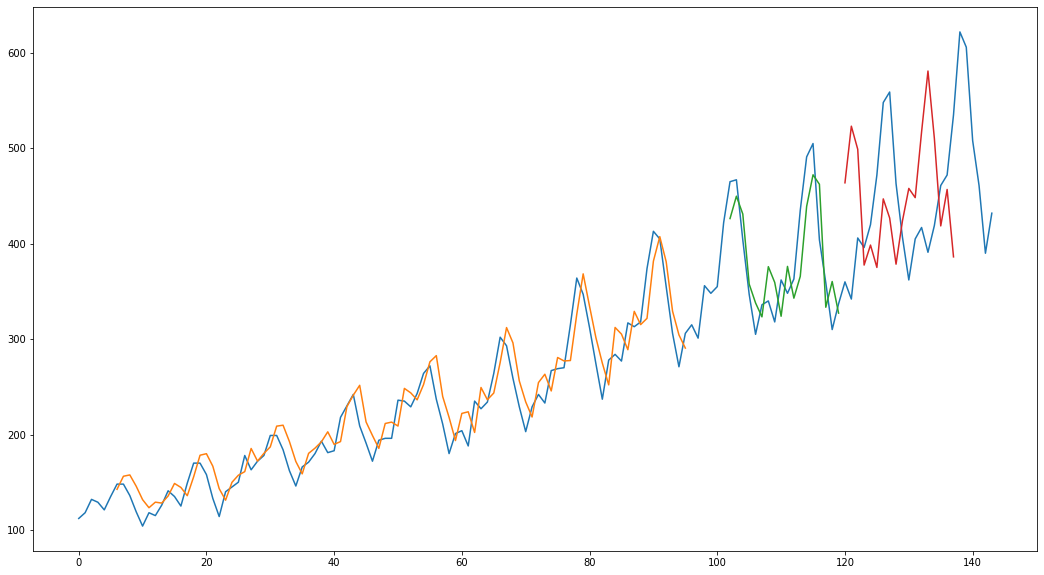

In [227]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## Shorter input window size performs much better. Let's try further decreasing it to 3 months.

In [228]:
input_window_size = 3
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 93, validation samples: 21, test samples: 21


In [229]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/{approach}_{input_window_size}")

Train on 93 samples, validate on 21 samples
Epoch 1/100
93/93 [==============================] - ETA: 1s - loss: 0.0566 - mean_absolute_error: 0.205 - 1s 12ms/sample - loss: 0.0602 - mean_absolute_error: 0.2068 - val_loss: 0.2581 - val_mean_absolute_error: 0.4955
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.0529 - mean_absolute_error: 0.196 - 0s 316us/sample - loss: 0.0513 - mean_absolute_error: 0.1861 - val_loss: 0.2310 - val_mean_absolute_error: 0.4674
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.0473 - mean_absolute_error: 0.183 - 0s 297us/sample - loss: 0.0432 - mean_absolute_error: 0.1665 - val_loss: 0.2049 - val_mean_absolute_error: 0.4387
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.0403 - mean_absolute_error: 0.172 - 0s 281us/sample - loss: 0.0358 - mean_absolute_error: 0.1485 - val_loss: 0.1813 - val_mean_absolute_error: 0.4111
Epoch 5/100
93/93 [==============================] - ETA: 0s - loss: 0.04

Epoch 13/100
93/93 [==============================] - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.140 - 0s 196us/sample - loss: 0.0316 - mean_absolute_error: 0.1360 - val_loss: 0.1884 - val_mean_absolute_error: 0.4191
Epoch 14/100
93/93 [==============================] - ETA: 0s - loss: 0.0289 - mean_absolute_error: 0.130 - 0s 177us/sample - loss: 0.0295 - mean_absolute_error: 0.1315 - val_loss: 0.1796 - val_mean_absolute_error: 0.4084
Epoch 15/100
93/93 [==============================] - ETA: 0s - loss: 0.0400 - mean_absolute_error: 0.156 - 0s 217us/sample - loss: 0.0275 - mean_absolute_error: 0.1266 - val_loss: 0.1718 - val_mean_absolute_error: 0.3987
Epoch 16/100
93/93 [==============================] - ETA: 0s - loss: 0.0226 - mean_absolute_error: 0.106 - 0s 207us/sample - loss: 0.0253 - mean_absolute_error: 0.1209 - val_loss: 0.1623 - val_mean_absolute_error: 0.3868
Epoch 17/100
93/93 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.119 - 0s 2

Epoch 50/100
93/93 [==============================] - ETA: 0s - loss: 0.0023 - mean_absolute_error: 0.035 - 0s 380us/sample - loss: 0.0037 - mean_absolute_error: 0.0460 - val_loss: 0.0177 - val_mean_absolute_error: 0.1003
Epoch 51/100
93/93 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.045 - 0s 282us/sample - loss: 0.0037 - mean_absolute_error: 0.0461 - val_loss: 0.0174 - val_mean_absolute_error: 0.0994
Epoch 52/100
93/93 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.053 - 0s 227us/sample - loss: 0.0036 - mean_absolute_error: 0.0445 - val_loss: 0.0174 - val_mean_absolute_error: 0.0994
Epoch 53/100
93/93 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.048 - 0s 203us/sample - loss: 0.0036 - mean_absolute_error: 0.0441 - val_loss: 0.0175 - val_mean_absolute_error: 0.0996
Epoch 54/100
93/93 [==============================] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.041 - 0s 1

Epoch 31/100
93/93 [==============================] - ETA: 0s - loss: 0.0327 - mean_absolute_error: 0.138 - 0s 175us/sample - loss: 0.0252 - mean_absolute_error: 0.1208 - val_loss: 0.1706 - val_mean_absolute_error: 0.3970
Epoch 32/100
93/93 [==============================] - ETA: 0s - loss: 0.0241 - mean_absolute_error: 0.120 - 0s 178us/sample - loss: 0.0245 - mean_absolute_error: 0.1194 - val_loss: 0.1674 - val_mean_absolute_error: 0.3930
Epoch 33/100
93/93 [==============================] - ETA: 0s - loss: 0.0164 - mean_absolute_error: 0.091 - 0s 203us/sample - loss: 0.0239 - mean_absolute_error: 0.1180 - val_loss: 0.1644 - val_mean_absolute_error: 0.3891
Epoch 34/100
93/93 [==============================] - ETA: 0s - loss: 0.0308 - mean_absolute_error: 0.127 - 0s 197us/sample - loss: 0.0234 - mean_absolute_error: 0.1169 - val_loss: 0.1614 - val_mean_absolute_error: 0.3852
Epoch 35/100
93/93 [==============================] - ETA: 0s - loss: 0.0222 - mean_absolute_error: 0.121 - 0s 1

Epoch 68/100
93/93 [==============================] - ETA: 0s - loss: 0.0155 - mean_absolute_error: 0.102 - 0s 240us/sample - loss: 0.0186 - mean_absolute_error: 0.1122 - val_loss: 0.1161 - val_mean_absolute_error: 0.3211
Epoch 69/100
93/93 [==============================] - ETA: 0s - loss: 0.0188 - mean_absolute_error: 0.110 - 0s 221us/sample - loss: 0.0186 - mean_absolute_error: 0.1122 - val_loss: 0.1158 - val_mean_absolute_error: 0.3206
Epoch 70/100
93/93 [==============================] - ETA: 0s - loss: 0.0230 - mean_absolute_error: 0.127 - 0s 225us/sample - loss: 0.0186 - mean_absolute_error: 0.1123 - val_loss: 0.1156 - val_mean_absolute_error: 0.3203
Epoch 71/100
93/93 [==============================] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.104 - 0s 265us/sample - loss: 0.0186 - mean_absolute_error: 0.1123 - val_loss: 0.1154 - val_mean_absolute_error: 0.3200
Epoch 72/100
93/93 [==============================] - ETA: 0s - loss: 0.0114 - mean_absolute_error: 0.090 - 0s 2

Train on 93 samples, validate on 21 samples
Epoch 1/100
93/93 [==============================] - ETA: 1s - loss: 0.0468 - mean_absolute_error: 0.188 - 1s 10ms/sample - loss: 0.0597 - mean_absolute_error: 0.2063 - val_loss: 0.2626 - val_mean_absolute_error: 0.5001
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.0653 - mean_absolute_error: 0.217 - 0s 188us/sample - loss: 0.0547 - mean_absolute_error: 0.1946 - val_loss: 0.2461 - val_mean_absolute_error: 0.4834
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.206 - 0s 195us/sample - loss: 0.0496 - mean_absolute_error: 0.1830 - val_loss: 0.2300 - val_mean_absolute_error: 0.4665
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.0623 - mean_absolute_error: 0.211 - 0s 189us/sample - loss: 0.0449 - mean_absolute_error: 0.1717 - val_loss: 0.2144 - val_mean_absolute_error: 0.4495
Epoch 5/100
93/93 [==============================] - ETA: 0s - loss: 0.03

Epoch 38/100
93/93 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.058 - 0s 255us/sample - loss: 0.0052 - mean_absolute_error: 0.0584 - val_loss: 0.0228 - val_mean_absolute_error: 0.1240
Epoch 39/100
93/93 [==============================] - ETA: 0s - loss: 0.0054 - mean_absolute_error: 0.058 - 0s 243us/sample - loss: 0.0050 - mean_absolute_error: 0.0573 - val_loss: 0.0221 - val_mean_absolute_error: 0.1221
Epoch 40/100
93/93 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.051 - 0s 251us/sample - loss: 0.0049 - mean_absolute_error: 0.0562 - val_loss: 0.0214 - val_mean_absolute_error: 0.1200
Epoch 41/100
93/93 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.051 - 0s 241us/sample - loss: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0205 - val_mean_absolute_error: 0.1168
Epoch 42/100
93/93 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.049 - 0s 2

Epoch 10/100
93/93 [==============================] - ETA: 0s - loss: 0.0422 - mean_absolute_error: 0.151 - 0s 157us/sample - loss: 0.0281 - mean_absolute_error: 0.1280 - val_loss: 0.1593 - val_mean_absolute_error: 0.3831
Epoch 11/100
93/93 [==============================] - ETA: 0s - loss: 0.0163 - mean_absolute_error: 0.103 - 0s 182us/sample - loss: 0.0252 - mean_absolute_error: 0.1210 - val_loss: 0.1480 - val_mean_absolute_error: 0.3682
Epoch 12/100
93/93 [==============================] - ETA: 0s - loss: 0.0170 - mean_absolute_error: 0.108 - 0s 165us/sample - loss: 0.0227 - mean_absolute_error: 0.1145 - val_loss: 0.1371 - val_mean_absolute_error: 0.3532
Epoch 13/100
93/93 [==============================] - ETA: 0s - loss: 0.0237 - mean_absolute_error: 0.114 - 0s 186us/sample - loss: 0.0204 - mean_absolute_error: 0.1078 - val_loss: 0.1265 - val_mean_absolute_error: 0.3379
Epoch 14/100
93/93 [==============================] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.107 - 0s 2

Epoch 47/100
93/93 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.058 - 0s 193us/sample - loss: 0.0059 - mean_absolute_error: 0.0618 - val_loss: 0.0282 - val_mean_absolute_error: 0.1373
Epoch 48/100
93/93 [==============================] - ETA: 0s - loss: 0.0086 - mean_absolute_error: 0.074 - 0s 212us/sample - loss: 0.0056 - mean_absolute_error: 0.0602 - val_loss: 0.0268 - val_mean_absolute_error: 0.1341
Epoch 49/100
93/93 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.051 - 0s 201us/sample - loss: 0.0054 - mean_absolute_error: 0.0587 - val_loss: 0.0255 - val_mean_absolute_error: 0.1311
Epoch 50/100
93/93 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.053 - 0s 196us/sample - loss: 0.0052 - mean_absolute_error: 0.0576 - val_loss: 0.0242 - val_mean_absolute_error: 0.1277
Epoch 51/100
93/93 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.051 - 0s 1

Epoch 8/100
93/93 [==============================] - ETA: 0s - loss: 0.0593 - mean_absolute_error: 0.192 - 0s 219us/sample - loss: 0.0428 - mean_absolute_error: 0.1597 - val_loss: 0.2351 - val_mean_absolute_error: 0.4705
Epoch 9/100
93/93 [==============================] - ETA: 0s - loss: 0.0381 - mean_absolute_error: 0.149 - 0s 184us/sample - loss: 0.0377 - mean_absolute_error: 0.1486 - val_loss: 0.2167 - val_mean_absolute_error: 0.4505
Epoch 10/100
93/93 [==============================] - ETA: 0s - loss: 0.0318 - mean_absolute_error: 0.130 - 0s 209us/sample - loss: 0.0333 - mean_absolute_error: 0.1383 - val_loss: 0.1981 - val_mean_absolute_error: 0.4294
Epoch 11/100
93/93 [==============================] - ETA: 0s - loss: 0.0424 - mean_absolute_error: 0.163 - 0s 208us/sample - loss: 0.0294 - mean_absolute_error: 0.1293 - val_loss: 0.1796 - val_mean_absolute_error: 0.4074
Epoch 12/100
93/93 [==============================] - ETA: 0s - loss: 0.0196 - mean_absolute_error: 0.110 - 0s 211

Epoch 45/100
93/93 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.071 - 0s 204us/sample - loss: 0.0055 - mean_absolute_error: 0.0606 - val_loss: 0.0250 - val_mean_absolute_error: 0.1289
Epoch 46/100
93/93 [==============================] - ETA: 0s - loss: 0.0072 - mean_absolute_error: 0.067 - 0s 185us/sample - loss: 0.0053 - mean_absolute_error: 0.0592 - val_loss: 0.0242 - val_mean_absolute_error: 0.1270
Epoch 47/100
93/93 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.067 - 0s 201us/sample - loss: 0.0052 - mean_absolute_error: 0.0583 - val_loss: 0.0237 - val_mean_absolute_error: 0.1258
Epoch 48/100
93/93 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.046 - 0s 198us/sample - loss: 0.0051 - mean_absolute_error: 0.0571 - val_loss: 0.0228 - val_mean_absolute_error: 0.1231
Epoch 49/100
93/93 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.062 - 0s 1

Train on 93 samples, validate on 21 samples
Epoch 1/100
93/93 [==============================] - ETA: 1s - loss: 0.0666 - mean_absolute_error: 0.225 - 1s 11ms/sample - loss: 0.0643 - mean_absolute_error: 0.2144 - val_loss: 0.2906 - val_mean_absolute_error: 0.5270
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.0655 - mean_absolute_error: 0.207 - 0s 233us/sample - loss: 0.0611 - mean_absolute_error: 0.2066 - val_loss: 0.2809 - val_mean_absolute_error: 0.5177
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.0654 - mean_absolute_error: 0.222 - 0s 266us/sample - loss: 0.0565 - mean_absolute_error: 0.1954 - val_loss: 0.2667 - val_mean_absolute_error: 0.5038
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.0574 - mean_absolute_error: 0.200 - 0s 238us/sample - loss: 0.0525 - mean_absolute_error: 0.1850 - val_loss: 0.2519 - val_mean_absolute_error: 0.4890
Epoch 5/100
93/93 [==============================] - ETA: 0s - loss: 0.05

Epoch 38/100
93/93 [==============================] - ETA: 0s - loss: 0.0065 - mean_absolute_error: 0.064 - 0s 280us/sample - loss: 0.0052 - mean_absolute_error: 0.0561 - val_loss: 0.0264 - val_mean_absolute_error: 0.1296
Epoch 39/100
93/93 [==============================] - ETA: 0s - loss: 0.0060 - mean_absolute_error: 0.058 - 0s 292us/sample - loss: 0.0046 - mean_absolute_error: 0.0520 - val_loss: 0.0248 - val_mean_absolute_error: 0.1241
Epoch 40/100
93/93 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.055 - 0s 261us/sample - loss: 0.0042 - mean_absolute_error: 0.0516 - val_loss: 0.0238 - val_mean_absolute_error: 0.1211
Epoch 41/100
93/93 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.051 - 0s 259us/sample - loss: 0.0059 - mean_absolute_error: 0.0542 - val_loss: 0.0230 - val_mean_absolute_error: 0.1184
Epoch 42/100
93/93 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.046 - 0s 2

Epoch 18/100
93/93 [==============================] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.112 - 0s 187us/sample - loss: 0.0146 - mean_absolute_error: 0.0951 - val_loss: 0.0713 - val_mean_absolute_error: 0.2433
Epoch 19/100
93/93 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.093 - 0s 182us/sample - loss: 0.0130 - mean_absolute_error: 0.0919 - val_loss: 0.0678 - val_mean_absolute_error: 0.2360
Epoch 20/100
93/93 [==============================] - ETA: 0s - loss: 0.0135 - mean_absolute_error: 0.097 - 0s 164us/sample - loss: 0.0155 - mean_absolute_error: 0.0992 - val_loss: 0.0649 - val_mean_absolute_error: 0.2298
Epoch 21/100
93/93 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.088 - 0s 172us/sample - loss: 0.0118 - mean_absolute_error: 0.0874 - val_loss: 0.0627 - val_mean_absolute_error: 0.2250
Epoch 22/100
93/93 [==============================] - ETA: 0s - loss: 0.0091 - mean_absolute_error: 0.076 - 0s 1

Epoch 55/100
93/93 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.050 - 0s 185us/sample - loss: 0.0058 - mean_absolute_error: 0.0570 - val_loss: 0.0180 - val_mean_absolute_error: 0.1056
Epoch 56/100
93/93 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.050 - 0s 186us/sample - loss: 0.0041 - mean_absolute_error: 0.0459 - val_loss: 0.0178 - val_mean_absolute_error: 0.1047
Epoch 57/100
93/93 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.056 - 0s 185us/sample - loss: 0.0067 - mean_absolute_error: 0.0562 - val_loss: 0.0174 - val_mean_absolute_error: 0.1032
Epoch 58/100
93/93 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.058 - 0s 196us/sample - loss: 0.0072 - mean_absolute_error: 0.0601 - val_loss: 0.0172 - val_mean_absolute_error: 0.1021
Epoch 59/100
93/93 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.046 - 0s 2

Epoch 26/100
93/93 [==============================] - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.136 - 0s 210us/sample - loss: 0.0342 - mean_absolute_error: 0.1421 - val_loss: 0.2030 - val_mean_absolute_error: 0.4360
Epoch 27/100
93/93 [==============================] - ETA: 0s - loss: 0.0508 - mean_absolute_error: 0.180 - 0s 185us/sample - loss: 0.0325 - mean_absolute_error: 0.1384 - val_loss: 0.1986 - val_mean_absolute_error: 0.4310
Epoch 28/100
93/93 [==============================] - ETA: 0s - loss: 0.0286 - mean_absolute_error: 0.121 - 0s 173us/sample - loss: 0.0317 - mean_absolute_error: 0.1365 - val_loss: 0.1942 - val_mean_absolute_error: 0.4259
Epoch 29/100
93/93 [==============================] - ETA: 0s - loss: 0.0229 - mean_absolute_error: 0.116 - 0s 173us/sample - loss: 0.0309 - mean_absolute_error: 0.1350 - val_loss: 0.1898 - val_mean_absolute_error: 0.4207
Epoch 30/100
93/93 [==============================] - ETA: 0s - loss: 0.0372 - mean_absolute_error: 0.150 - 0s 1

Epoch 63/100
93/93 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.056 - 0s 186us/sample - loss: 0.0050 - mean_absolute_error: 0.0513 - val_loss: 0.0357 - val_mean_absolute_error: 0.1551
Epoch 64/100
93/93 [==============================] - ETA: 0s - loss: 0.0120 - mean_absolute_error: 0.065 - 0s 208us/sample - loss: 0.0100 - mean_absolute_error: 0.0657 - val_loss: 0.0339 - val_mean_absolute_error: 0.1502
Epoch 65/100
93/93 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.056 - 0s 169us/sample - loss: 0.0059 - mean_absolute_error: 0.0550 - val_loss: 0.0323 - val_mean_absolute_error: 0.1458
Epoch 66/100
93/93 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.056 - 0s 154us/sample - loss: 0.0070 - mean_absolute_error: 0.0596 - val_loss: 0.0308 - val_mean_absolute_error: 0.1414
Epoch 67/100
93/93 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.042 - 0s 1

Train on 93 samples, validate on 21 samples
Epoch 1/100
93/93 [==============================] - ETA: 1s - loss: 0.0492 - mean_absolute_error: 0.194 - 1s 10ms/sample - loss: 0.0576 - mean_absolute_error: 0.2024 - val_loss: 0.2539 - val_mean_absolute_error: 0.4913
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.0394 - mean_absolute_error: 0.168 - 0s 256us/sample - loss: 0.0527 - mean_absolute_error: 0.1913 - val_loss: 0.2384 - val_mean_absolute_error: 0.4753
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.0402 - mean_absolute_error: 0.168 - 0s 262us/sample - loss: 0.0479 - mean_absolute_error: 0.1803 - val_loss: 0.2234 - val_mean_absolute_error: 0.4593
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.0397 - mean_absolute_error: 0.165 - 0s 219us/sample - loss: 0.0437 - mean_absolute_error: 0.1698 - val_loss: 0.2088 - val_mean_absolute_error: 0.4432
Epoch 5/100
93/93 [==============================] - ETA: 0s - loss: 0.04

Epoch 38/100
93/93 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.045 - 0s 226us/sample - loss: 0.0040 - mean_absolute_error: 0.0498 - val_loss: 0.0191 - val_mean_absolute_error: 0.1105
Epoch 39/100
93/93 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.043 - 0s 246us/sample - loss: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0185 - val_mean_absolute_error: 0.1080
Epoch 40/100
93/93 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.047 - 0s 270us/sample - loss: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0179 - val_mean_absolute_error: 0.1059
Epoch 41/100
93/93 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.049 - 0s 255us/sample - loss: 0.0038 - mean_absolute_error: 0.0478 - val_loss: 0.0173 - val_mean_absolute_error: 0.1036
Epoch 42/100
93/93 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.046 - 0s 2

Epoch 14/100
93/93 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.080 - 0s 197us/sample - loss: 0.0149 - mean_absolute_error: 0.0930 - val_loss: 0.0966 - val_mean_absolute_error: 0.2904
Epoch 15/100
93/93 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.074 - 0s 242us/sample - loss: 0.0134 - mean_absolute_error: 0.0894 - val_loss: 0.0860 - val_mean_absolute_error: 0.2717
Epoch 16/100
93/93 [==============================] - ETA: 0s - loss: 0.0151 - mean_absolute_error: 0.088 - 0s 197us/sample - loss: 0.0123 - mean_absolute_error: 0.0865 - val_loss: 0.0765 - val_mean_absolute_error: 0.2536
Epoch 17/100
93/93 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.085 - 0s 210us/sample - loss: 0.0113 - mean_absolute_error: 0.0849 - val_loss: 0.0684 - val_mean_absolute_error: 0.2371
Epoch 18/100
93/93 [==============================] - ETA: 0s - loss: 0.0134 - mean_absolute_error: 0.096 - 0s 2

Epoch 51/100
93/93 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.058 - 0s 185us/sample - loss: 0.0040 - mean_absolute_error: 0.0485 - val_loss: 0.0168 - val_mean_absolute_error: 0.1024
Epoch 52/100
93/93 [==============================] - ETA: 0s - loss: 0.0031 - mean_absolute_error: 0.037 - 0s 187us/sample - loss: 0.0039 - mean_absolute_error: 0.0481 - val_loss: 0.0166 - val_mean_absolute_error: 0.1018
Epoch 53/100
93/93 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.050 - 0s 191us/sample - loss: 0.0039 - mean_absolute_error: 0.0479 - val_loss: 0.0165 - val_mean_absolute_error: 0.1016
Epoch 54/100
93/93 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.049 - 0s 207us/sample - loss: 0.0039 - mean_absolute_error: 0.0477 - val_loss: 0.0165 - val_mean_absolute_error: 0.1015
Epoch 55/100
93/93 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.047 - 0s 2

Epoch 25/100
93/93 [==============================] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.077 - 0s 189us/sample - loss: 0.0093 - mean_absolute_error: 0.0762 - val_loss: 0.0598 - val_mean_absolute_error: 0.2186
Epoch 26/100
93/93 [==============================] - ETA: 0s - loss: 0.0124 - mean_absolute_error: 0.082 - 0s 191us/sample - loss: 0.0088 - mean_absolute_error: 0.0746 - val_loss: 0.0548 - val_mean_absolute_error: 0.2067
Epoch 27/100
93/93 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.075 - 0s 180us/sample - loss: 0.0082 - mean_absolute_error: 0.0722 - val_loss: 0.0508 - val_mean_absolute_error: 0.1968
Epoch 28/100
93/93 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.072 - 0s 186us/sample - loss: 0.0077 - mean_absolute_error: 0.0701 - val_loss: 0.0472 - val_mean_absolute_error: 0.1877
Epoch 29/100
93/93 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.064 - 0s 2

Train on 93 samples, validate on 21 samples
Epoch 1/100
93/93 [==============================] - ETA: 1s - loss: 0.0499 - mean_absolute_error: 0.193 - 1s 9ms/sample - loss: 0.0557 - mean_absolute_error: 0.1991 - val_loss: 0.2496 - val_mean_absolute_error: 0.4870
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.0474 - mean_absolute_error: 0.181 - 0s 227us/sample - loss: 0.0530 - mean_absolute_error: 0.1927 - val_loss: 0.2418 - val_mean_absolute_error: 0.4789
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.0461 - mean_absolute_error: 0.181 - 0s 252us/sample - loss: 0.0504 - mean_absolute_error: 0.1863 - val_loss: 0.2341 - val_mean_absolute_error: 0.4708
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.0500 - mean_absolute_error: 0.183 - 0s 209us/sample - loss: 0.0478 - mean_absolute_error: 0.1800 - val_loss: 0.2264 - val_mean_absolute_error: 0.4626
Epoch 5/100
93/93 [==============================] - ETA: 0s - loss: 0.043

Epoch 38/100
93/93 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.070 - 0s 220us/sample - loss: 0.0089 - mean_absolute_error: 0.0768 - val_loss: 0.0481 - val_mean_absolute_error: 0.1901
Epoch 39/100
93/93 [==============================] - ETA: 0s - loss: 0.0098 - mean_absolute_error: 0.086 - 0s 220us/sample - loss: 0.0087 - mean_absolute_error: 0.0759 - val_loss: 0.0469 - val_mean_absolute_error: 0.1870
Epoch 40/100
93/93 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.080 - 0s 215us/sample - loss: 0.0085 - mean_absolute_error: 0.0749 - val_loss: 0.0455 - val_mean_absolute_error: 0.1832
Epoch 41/100
93/93 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.069 - 0s 212us/sample - loss: 0.0083 - mean_absolute_error: 0.0740 - val_loss: 0.0445 - val_mean_absolute_error: 0.1803
Epoch 42/100
93/93 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.069 - 0s 2

Epoch 75/100
93/93 [==============================] - ETA: 0s - loss: 0.0024 - mean_absolute_error: 0.038 - 0s 222us/sample - loss: 0.0040 - mean_absolute_error: 0.0502 - val_loss: 0.0171 - val_mean_absolute_error: 0.1045
Epoch 76/100
93/93 [==============================] - ETA: 0s - loss: 0.0045 - mean_absolute_error: 0.050 - 0s 215us/sample - loss: 0.0040 - mean_absolute_error: 0.0499 - val_loss: 0.0169 - val_mean_absolute_error: 0.1036
Epoch 77/100
93/93 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.046 - 0s 237us/sample - loss: 0.0040 - mean_absolute_error: 0.0497 - val_loss: 0.0169 - val_mean_absolute_error: 0.1035
Epoch 78/100
93/93 [==============================] - ETA: 0s - loss: 0.0049 - mean_absolute_error: 0.055 - 0s 222us/sample - loss: 0.0040 - mean_absolute_error: 0.0493 - val_loss: 0.0168 - val_mean_absolute_error: 0.1031
Epoch 79/100
93/93 [==============================] - ETA: 0s - loss: 0.0035 - mean_absolute_error: 0.045 - 0s 1

Epoch 20/100
93/93 [==============================] - ETA: 0s - loss: 0.0071 - mean_absolute_error: 0.064 - 0s 162us/sample - loss: 0.0125 - mean_absolute_error: 0.0863 - val_loss: 0.0793 - val_mean_absolute_error: 0.2592
Epoch 21/100
93/93 [==============================] - ETA: 0s - loss: 0.0087 - mean_absolute_error: 0.075 - 0s 182us/sample - loss: 0.0118 - mean_absolute_error: 0.0853 - val_loss: 0.0737 - val_mean_absolute_error: 0.2481
Epoch 22/100
93/93 [==============================] - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.066 - 0s 179us/sample - loss: 0.0113 - mean_absolute_error: 0.0841 - val_loss: 0.0687 - val_mean_absolute_error: 0.2379
Epoch 23/100
93/93 [==============================] - ETA: 0s - loss: 0.0126 - mean_absolute_error: 0.093 - 0s 167us/sample - loss: 0.0110 - mean_absolute_error: 0.0842 - val_loss: 0.0641 - val_mean_absolute_error: 0.2281
Epoch 24/100
93/93 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.082 - 0s 1

Epoch 57/100
93/93 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.055 - 0s 183us/sample - loss: 0.0069 - mean_absolute_error: 0.0682 - val_loss: 0.0308 - val_mean_absolute_error: 0.1432
Epoch 58/100
93/93 [==============================] - ETA: 0s - loss: 0.0067 - mean_absolute_error: 0.067 - 0s 173us/sample - loss: 0.0068 - mean_absolute_error: 0.0678 - val_loss: 0.0304 - val_mean_absolute_error: 0.1423
Epoch 59/100
93/93 [==============================] - ETA: 0s - loss: 0.0082 - mean_absolute_error: 0.072 - 0s 182us/sample - loss: 0.0067 - mean_absolute_error: 0.0674 - val_loss: 0.0298 - val_mean_absolute_error: 0.1412
Epoch 60/100
93/93 [==============================] - ETA: 0s - loss: 0.0066 - mean_absolute_error: 0.065 - 0s 163us/sample - loss: 0.0066 - mean_absolute_error: 0.0670 - val_loss: 0.0293 - val_mean_absolute_error: 0.1402
Epoch 61/100
93/93 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.078 - 0s 1

Epoch 94/100
93/93 [==============================] - ETA: 0s - loss: 0.0029 - mean_absolute_error: 0.041 - 0s 172us/sample - loss: 0.0039 - mean_absolute_error: 0.0493 - val_loss: 0.0168 - val_mean_absolute_error: 0.1085
Epoch 95/100
93/93 [==============================] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.044 - 0s 153us/sample - loss: 0.0039 - mean_absolute_error: 0.0491 - val_loss: 0.0168 - val_mean_absolute_error: 0.1081
Epoch 96/100
93/93 [==============================] - ETA: 0s - loss: 0.0051 - mean_absolute_error: 0.058 - 0s 168us/sample - loss: 0.0039 - mean_absolute_error: 0.0489 - val_loss: 0.0167 - val_mean_absolute_error: 0.1080
Epoch 97/100
93/93 [==============================] - ETA: 0s - loss: 0.0058 - mean_absolute_error: 0.060 - 0s 201us/sample - loss: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0167 - val_mean_absolute_error: 0.1079
Epoch 98/100
93/93 [==============================] - ETA: 0s - loss: 0.0030 - mean_absolute_error: 0.043 - 0s 1

Epoch 31/100
93/93 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.124 - 0s 184us/sample - loss: 0.0246 - mean_absolute_error: 0.1173 - val_loss: 0.1707 - val_mean_absolute_error: 0.3968
Epoch 32/100
93/93 [==============================] - ETA: 0s - loss: 0.0185 - mean_absolute_error: 0.099 - 0s 173us/sample - loss: 0.0235 - mean_absolute_error: 0.1144 - val_loss: 0.1656 - val_mean_absolute_error: 0.3903
Epoch 33/100
93/93 [==============================] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.110 - 0s 175us/sample - loss: 0.0225 - mean_absolute_error: 0.1119 - val_loss: 0.1604 - val_mean_absolute_error: 0.3837
Epoch 34/100
93/93 [==============================] - ETA: 0s - loss: 0.0256 - mean_absolute_error: 0.115 - 0s 161us/sample - loss: 0.0216 - mean_absolute_error: 0.1092 - val_loss: 0.1553 - val_mean_absolute_error: 0.3771
Epoch 35/100
93/93 [==============================] - ETA: 0s - loss: 0.0248 - mean_absolute_error: 0.120 - 0s 1

Epoch 68/100
93/93 [==============================] - ETA: 0s - loss: 0.0036 - mean_absolute_error: 0.048 - 0s 168us/sample - loss: 0.0048 - mean_absolute_error: 0.0519 - val_loss: 0.0414 - val_mean_absolute_error: 0.1705
Epoch 69/100
93/93 [==============================] - ETA: 0s - loss: 0.0037 - mean_absolute_error: 0.047 - 0s 161us/sample - loss: 0.0046 - mean_absolute_error: 0.0506 - val_loss: 0.0397 - val_mean_absolute_error: 0.1653
Epoch 70/100
93/93 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.053 - 0s 153us/sample - loss: 0.0045 - mean_absolute_error: 0.0496 - val_loss: 0.0380 - val_mean_absolute_error: 0.1603
Epoch 71/100
93/93 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.046 - 0s 153us/sample - loss: 0.0043 - mean_absolute_error: 0.0488 - val_loss: 0.0365 - val_mean_absolute_error: 0.1559
Epoch 72/100
93/93 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.045 - 0s 1

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/univariate_3/assets


In [230]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 30.64 RMSE
Validation Score: 66.13 RMSE
Test Score: 99.64 RMSE


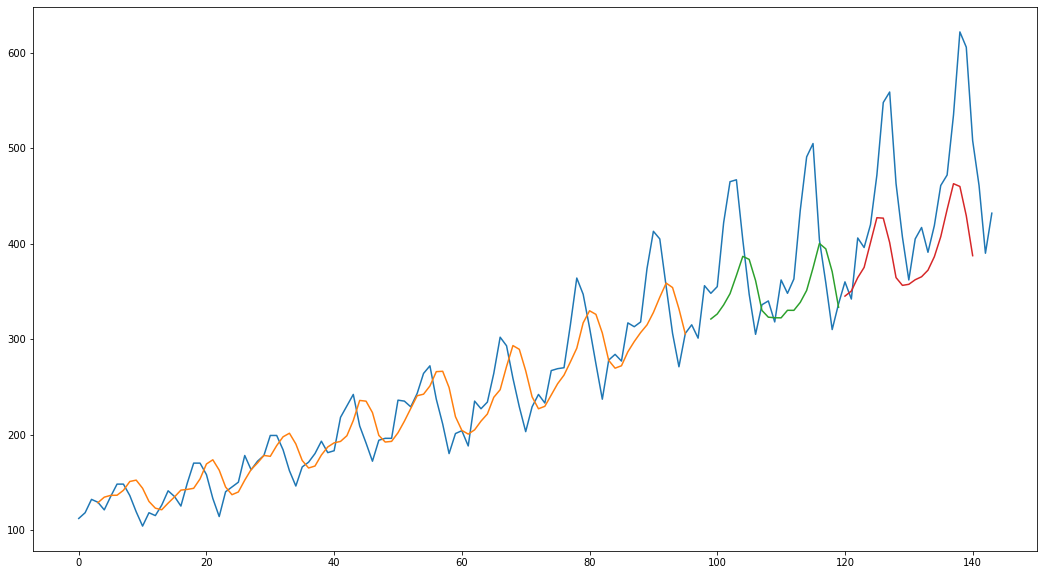

In [231]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## Let's keep the input window size equal to 6 and try changing the network architecture a little bit. Let's get rid of the dropout layer.

In [232]:
input_window_size = 6
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(train_set, validation_set, test_set, input_window_size, output_window_size)

Number of training samples: 90, validation samples: 18, test samples: 18


In [233]:
def build_modified_model(hp):
    model = Sequential()
    # input LSTM layer
    model.add(LSTM(hp.Int("input_units", min_value=5, max_value=50, step=3),
                   activation='relu', input_shape=(input_window_size, 1), name="lstm"))
    
    # dense hidden layers with dropouts
    for i in range(hp.Int("n_layers", 0,2)):
        model.add(Dense(hp.Int(f"dense_{i}_units", min_value=5, max_value=50, step=3),
                        activation='relu', name=f"hidden_{i}"))    
    # dense output layer
    model.add(Dense(1, name="output"))
    model.compile(loss='mean_squared_error' , optimizer=Adam(learning_rate=
            hp.Choice("learning_rate",values=[1e-2, 1e-3, 1e-4])), metrics=[metrics.mae])
    return model

In [234]:
approach = "univariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_modified_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/modified_architecture_{approach}_{input_window_size}")

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0662 - mean_absolute_error: 0.228 - 1s 12ms/sample - loss: 0.0608 - mean_absolute_error: 0.2097 - val_loss: 0.2545 - val_mean_absolute_error: 0.4899
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0536 - mean_absolute_error: 0.190 - 0s 287us/sample - loss: 0.0528 - mean_absolute_error: 0.1923 - val_loss: 0.2289 - val_mean_absolute_error: 0.4629
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.147 - 0s 315us/sample - loss: 0.0454 - mean_absolute_error: 0.1754 - val_loss: 0.2045 - val_mean_absolute_error: 0.4357
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0475 - mean_absolute_error: 0.180 - 0s 316us/sample - loss: 0.0393 - mean_absolute_error: 0.1597 - val_loss: 0.1806 - val_mean_absolute_error: 0.4071
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.03

Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0687 - mean_absolute_error: 0.229 - 0s 280us/sample - loss: 0.0624 - mean_absolute_error: 0.2099 - val_loss: 0.2727 - val_mean_absolute_error: 0.5080
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0640 - mean_absolute_error: 0.207 - 0s 318us/sample - loss: 0.0547 - mean_absolute_error: 0.1934 - val_loss: 0.2468 - val_mean_absolute_error: 0.4817
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0561 - mean_absolute_error: 0.197 - 0s 298us/sample - loss: 0.0476 - mean_absolute_error: 0.1777 - val_loss: 0.2219 - val_mean_absolute_error: 0.4551
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.0319 - mean_absolute_error: 0.156 - 0s 274us/sample - loss: 0.0408 - mean_absolute_error: 0.1631 - val_loss: 0.1983 - val_mean_absolute_error: 0.4282
Epoch 6/100
90/90 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.144 - 0s 268us/

Epoch 17/100
90/90 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.064 - 0s 156us/sample - loss: 0.0075 - mean_absolute_error: 0.0691 - val_loss: 0.0373 - val_mean_absolute_error: 0.1488


Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0471 - mean_absolute_error: 0.181 - 1s 12ms/sample - loss: 0.0328 - mean_absolute_error: 0.1408 - val_loss: 0.0386 - val_mean_absolute_error: 0.1532
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0140 - mean_absolute_error: 0.096 - 0s 315us/sample - loss: 0.0220 - mean_absolute_error: 0.1275 - val_loss: 0.0237 - val_mean_absolute_error: 0.1152
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0178 - mean_absolute_error: 0.119 - 0s 225us/sample - loss: 0.0117 - mean_absolute_error: 0.0913 - val_loss: 0.0671 - val_mean_absolute_error: 0.2266
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0090 - mean_absolute_error: 0.076 - 0s 214us/sample - loss: 0.0130 - mean_absolute_error: 0.0859 - val_loss: 0.0913 - val_mean_absolute_error: 0.2757
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.01

90/90 [==============================] - ETA: 0s - loss: 0.0143 - mean_absolute_error: 0.098 - 0s 214us/sample - loss: 0.0187 - mean_absolute_error: 0.1128 - val_loss: 0.0993 - val_mean_absolute_error: 0.2914
Epoch 14/100
90/90 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.079 - 0s 201us/sample - loss: 0.0188 - mean_absolute_error: 0.1131 - val_loss: 0.0997 - val_mean_absolute_error: 0.2920
Epoch 15/100
90/90 [==============================] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.111 - 0s 197us/sample - loss: 0.0187 - mean_absolute_error: 0.1129 - val_loss: 0.1008 - val_mean_absolute_error: 0.2939
Epoch 16/100
90/90 [==============================] - ETA: 0s - loss: 0.0161 - mean_absolute_error: 0.102 - 0s 202us/sample - loss: 0.0187 - mean_absolute_error: 0.1125 - val_loss: 0.1030 - val_mean_absolute_error: 0.2976
Epoch 17/100
90/90 [==============================] - ETA: 0s - loss: 0.0216 - mean_absolute_error: 0.125 - 0s 212us/sample -

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0769 - mean_absolute_error: 0.240 - 1s 10ms/sample - loss: 0.0579 - mean_absolute_error: 0.1957 - val_loss: 0.1783 - val_mean_absolute_error: 0.4051
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0326 - mean_absolute_error: 0.139 - 0s 248us/sample - loss: 0.0238 - mean_absolute_error: 0.1184 - val_loss: 0.0746 - val_mean_absolute_error: 0.2460
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0159 - mean_absolute_error: 0.106 - 0s 290us/sample - loss: 0.0192 - mean_absolute_error: 0.1155 - val_loss: 0.0440 - val_mean_absolute_error: 0.1730
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0212 - mean_absolute_error: 0.123 - 0s 190us/sample - loss: 0.0211 - mean_absolute_error: 0.1224 - val_loss: 0.0616 - val_mean_absolute_error: 0.2179
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.01

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0606 - mean_absolute_error: 0.215 - 1s 10ms/sample - loss: 0.0618 - mean_absolute_error: 0.2113 - val_loss: 0.2542 - val_mean_absolute_error: 0.4897
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.153 - 0s 264us/sample - loss: 0.0497 - mean_absolute_error: 0.1856 - val_loss: 0.2185 - val_mean_absolute_error: 0.4515
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0463 - mean_absolute_error: 0.162 - 0s 287us/sample - loss: 0.0414 - mean_absolute_error: 0.1655 - val_loss: 0.1876 - val_mean_absolute_error: 0.4155
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.150 - 0s 258us/sample - loss: 0.0343 - mean_absolute_error: 0.1473 - val_loss: 0.1638 - val_mean_absolute_error: 0.3857
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.02

Epoch 19/100
90/90 [==============================] - ETA: 0s - loss: 0.0088 - mean_absolute_error: 0.072 - 0s 193us/sample - loss: 0.0071 - mean_absolute_error: 0.0670 - val_loss: 0.0355 - val_mean_absolute_error: 0.1486
Epoch 20/100
90/90 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.056 - 0s 204us/sample - loss: 0.0068 - mean_absolute_error: 0.0647 - val_loss: 0.0325 - val_mean_absolute_error: 0.1399
Epoch 21/100
90/90 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.072 - 0s 302us/sample - loss: 0.0064 - mean_absolute_error: 0.0632 - val_loss: 0.0283 - val_mean_absolute_error: 0.1262
Epoch 22/100
90/90 [==============================] - ETA: 0s - loss: 0.0075 - mean_absolute_error: 0.072 - 0s 287us/sample - loss: 0.0059 - mean_absolute_error: 0.0615 - val_loss: 0.0256 - val_mean_absolute_error: 0.1189
Epoch 23/100
90/90 [==============================] - ETA: 0s - loss: 0.0068 - mean_absolute_error: 0.063 - 0s 2

Epoch 16/100
90/90 [==============================] - ETA: 0s - loss: 0.0095 - mean_absolute_error: 0.085 - 0s 212us/sample - loss: 0.0087 - mean_absolute_error: 0.0767 - val_loss: 0.0409 - val_mean_absolute_error: 0.1614
Epoch 17/100
90/90 [==============================] - ETA: 0s - loss: 0.0100 - mean_absolute_error: 0.082 - 0s 208us/sample - loss: 0.0080 - mean_absolute_error: 0.0727 - val_loss: 0.0414 - val_mean_absolute_error: 0.1630
Epoch 18/100
90/90 [==============================] - ETA: 0s - loss: 0.0109 - mean_absolute_error: 0.085 - 0s 206us/sample - loss: 0.0074 - mean_absolute_error: 0.0684 - val_loss: 0.0411 - val_mean_absolute_error: 0.1624
Epoch 19/100
90/90 [==============================] - ETA: 0s - loss: 0.0085 - mean_absolute_error: 0.073 - 0s 222us/sample - loss: 0.0069 - mean_absolute_error: 0.0648 - val_loss: 0.0396 - val_mean_absolute_error: 0.1593
Epoch 20/100
90/90 [==============================] - ETA: 0s - loss: 0.0079 - mean_absolute_error: 0.067 - 0s 2

Train on 90 samples, validate on 18 samples
Epoch 1/100
90/90 [==============================] - ETA: 1s - loss: 0.0652 - mean_absolute_error: 0.216 - 1s 10ms/sample - loss: 0.0677 - mean_absolute_error: 0.2224 - val_loss: 0.3015 - val_mean_absolute_error: 0.5358
Epoch 2/100
90/90 [==============================] - ETA: 0s - loss: 0.0554 - mean_absolute_error: 0.199 - 0s 284us/sample - loss: 0.0663 - mean_absolute_error: 0.2194 - val_loss: 0.2983 - val_mean_absolute_error: 0.5328
Epoch 3/100
90/90 [==============================] - ETA: 0s - loss: 0.0781 - mean_absolute_error: 0.233 - 0s 372us/sample - loss: 0.0651 - mean_absolute_error: 0.2165 - val_loss: 0.2952 - val_mean_absolute_error: 0.5298
Epoch 4/100
90/90 [==============================] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.222 - 0s 287us/sample - loss: 0.0638 - mean_absolute_error: 0.2136 - val_loss: 0.2920 - val_mean_absolute_error: 0.5269
Epoch 5/100
90/90 [==============================] - ETA: 0s - loss: 0.07

Epoch 38/100
90/90 [==============================] - ETA: 0s - loss: 0.0432 - mean_absolute_error: 0.153 - 0s 282us/sample - loss: 0.0333 - mean_absolute_error: 0.1407 - val_loss: 0.2053 - val_mean_absolute_error: 0.4369
Epoch 39/100
90/90 [==============================] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.120 - 0s 303us/sample - loss: 0.0328 - mean_absolute_error: 0.1393 - val_loss: 0.2034 - val_mean_absolute_error: 0.4347
Epoch 40/100
90/90 [==============================] - ETA: 0s - loss: 0.0239 - mean_absolute_error: 0.115 - 0s 331us/sample - loss: 0.0322 - mean_absolute_error: 0.1381 - val_loss: 0.2015 - val_mean_absolute_error: 0.4326
Epoch 41/100
90/90 [==============================] - ETA: 0s - loss: 0.0257 - mean_absolute_error: 0.128 - 0s 278us/sample - loss: 0.0318 - mean_absolute_error: 0.1368 - val_loss: 0.1996 - val_mean_absolute_error: 0.4304
Epoch 42/100
90/90 [==============================] - ETA: 0s - loss: 0.0216 - mean_absolute_error: 0.108 - 0s 2

Epoch 75/100
90/90 [==============================] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.103 - 0s 338us/sample - loss: 0.0214 - mean_absolute_error: 0.1129 - val_loss: 0.1521 - val_mean_absolute_error: 0.3711
Epoch 76/100
90/90 [==============================] - ETA: 0s - loss: 0.0179 - mean_absolute_error: 0.106 - 0s 342us/sample - loss: 0.0213 - mean_absolute_error: 0.1127 - val_loss: 0.1512 - val_mean_absolute_error: 0.3698
Epoch 77/100
90/90 [==============================] - ETA: 0s - loss: 0.0190 - mean_absolute_error: 0.105 - 0s 353us/sample - loss: 0.0211 - mean_absolute_error: 0.1123 - val_loss: 0.1502 - val_mean_absolute_error: 0.3685
Epoch 78/100
90/90 [==============================] - ETA: 0s - loss: 0.0203 - mean_absolute_error: 0.113 - 0s 353us/sample - loss: 0.0210 - mean_absolute_error: 0.1122 - val_loss: 0.1493 - val_mean_absolute_error: 0.3672
Epoch 79/100
90/90 [==============================] - ETA: 0s - loss: 0.0171 - mean_absolute_error: 0.094 - 0s 3

Epoch 12/100
90/90 [==============================] - ETA: 0s - loss: 0.0103 - mean_absolute_error: 0.080 - 0s 293us/sample - loss: 0.0114 - mean_absolute_error: 0.0879 - val_loss: 0.0408 - val_mean_absolute_error: 0.1596
Epoch 13/100
90/90 [==============================] - ETA: 0s - loss: 0.0097 - mean_absolute_error: 0.084 - 0s 276us/sample - loss: 0.0121 - mean_absolute_error: 0.0920 - val_loss: 0.0356 - val_mean_absolute_error: 0.1458
Epoch 14/100
90/90 [==============================] - ETA: 0s - loss: 0.0107 - mean_absolute_error: 0.086 - 0s 212us/sample - loss: 0.0119 - mean_absolute_error: 0.0914 - val_loss: 0.0366 - val_mean_absolute_error: 0.1487
Epoch 15/100
90/90 [==============================] - ETA: 0s - loss: 0.0092 - mean_absolute_error: 0.076 - 0s 199us/sample - loss: 0.0112 - mean_absolute_error: 0.0878 - val_loss: 0.0412 - val_mean_absolute_error: 0.1609
Epoch 16/100
90/90 [==============================] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.087 - 0s 2

Epoch 31/100
90/90 [==============================] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.155 - 0s 210us/sample - loss: 0.0377 - mean_absolute_error: 0.1511 - val_loss: 0.2201 - val_mean_absolute_error: 0.4536
Epoch 32/100
90/90 [==============================] - ETA: 0s - loss: 0.0405 - mean_absolute_error: 0.161 - 0s 207us/sample - loss: 0.0371 - mean_absolute_error: 0.1495 - val_loss: 0.2180 - val_mean_absolute_error: 0.4512
Epoch 33/100
90/90 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.155 - 0s 206us/sample - loss: 0.0364 - mean_absolute_error: 0.1479 - val_loss: 0.2158 - val_mean_absolute_error: 0.4488
Epoch 34/100
90/90 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.132 - 0s 202us/sample - loss: 0.0358 - mean_absolute_error: 0.1465 - val_loss: 0.2137 - val_mean_absolute_error: 0.4465
Epoch 35/100
90/90 [==============================] - ETA: 0s - loss: 0.0436 - mean_absolute_error: 0.171 - 0s 2

Epoch 68/100
90/90 [==============================] - ETA: 0s - loss: 0.0260 - mean_absolute_error: 0.124 - 0s 201us/sample - loss: 0.0227 - mean_absolute_error: 0.1153 - val_loss: 0.1598 - val_mean_absolute_error: 0.3813
Epoch 69/100
90/90 [==============================] - ETA: 0s - loss: 0.0118 - mean_absolute_error: 0.082 - 0s 220us/sample - loss: 0.0225 - mean_absolute_error: 0.1150 - val_loss: 0.1587 - val_mean_absolute_error: 0.3799
Epoch 70/100
90/90 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.120 - 0s 217us/sample - loss: 0.0223 - mean_absolute_error: 0.1147 - val_loss: 0.1576 - val_mean_absolute_error: 0.3783
Epoch 71/100
90/90 [==============================] - ETA: 0s - loss: 0.0247 - mean_absolute_error: 0.124 - 0s 219us/sample - loss: 0.0221 - mean_absolute_error: 0.1143 - val_loss: 0.1565 - val_mean_absolute_error: 0.3769
Epoch 72/100
90/90 [==============================] - ETA: 0s - loss: 0.0262 - mean_absolute_error: 0.128 - 0s 2

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ../models/modified_architecture_univariate_6/assets


In [235]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

# invert predictions
predictions_for_train_denormalized = scaler.inverse_transform(predictions_for_train)
true_values_train = scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = scaler.inverse_transform(predictions_for_validation)
true_values_val = scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = scaler.inverse_transform(predictions_for_test)
true_values_test = scaler.inverse_transform(test_samples[1])

# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 64.85 RMSE
Validation Score: 68.92 RMSE
Test Score: 100.10 RMSE


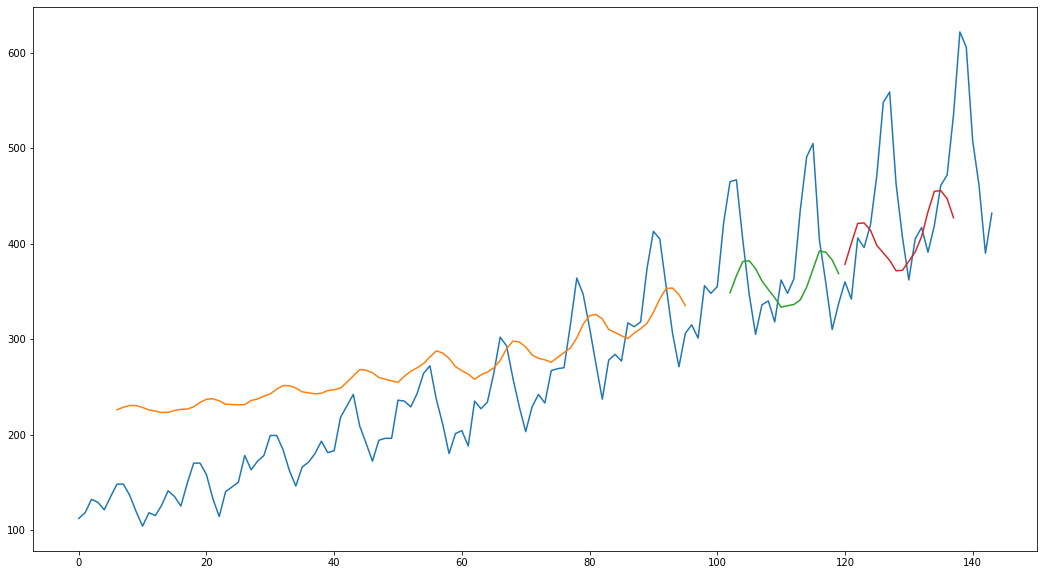

In [236]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(normalized_univariate_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(normalized_univariate_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(normalized_univariate_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(scaler.inverse_transform(normalized_univariate_array))
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()

## Getting rid of a dropout layer is not a good idea!

## Summary of the best performing model: input window size equal to 6 and the architecture defined in build_model function.

## Now let's try the multivariate approach in a different notebook.